In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parameters for sequence length handling
MAX_SEQ_LENGTH = 15  # Set a maximum sequence length
MIN_SEQ_LENGTH = 2  # Optional: Set a minimum sequence length
data_15 = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_15days_+-_onlyacr.csv")
# data_cleaned = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_45days_+-_onlyacr.csv")
data_cleaned = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_45days_+-_merged.csv")

# select time window
data_cleaned = data_cleaned.loc[data_cleaned["ady_dna"] <= 365 * 100]

######only select part of 15 days' samples:
######
# data_15 = data_15.loc[(data_15["label"] == 1) | (data_15["label"] == 0)]
# # only select part of 15 days' samples:
# subjid = data_15.loc[(data_15["label"] == 1) | (data_15["label"] == 0)]["usubjid"]
# data_15["x_label"] = data_15["label"]
# data_cleaned = data_cleaned.loc[data_cleaned["usubjid"].isin(subjid)]
# data_cleaned = data_cleaned.merge(data_15[["usubjid", "ady_dna", "x_label"]], on = ["usubjid", "ady_dna"], how = "left")

# change crit1fl
data_cleaned["crit1fl"] = data_cleaned["crit1fl"].ffill()
data_cleaned["crit1fl"].replace("N", 0, inplace = True)
data_cleaned["crit1fl"].replace("Y", 1, inplace = True)

# dsa
data_cleaned["aval_dsa"] = data_cleaned["aval_dsa"].ffill()
data_cleaned["aval_dsa"].replace("No", 0, inplace = True)
data_cleaned["aval_dsa"].replace("Yes", 1, inplace = True)

# map the features
def create_lag_features(df):
    # Set missing labels to -1
    # df['label'].fillna(-1, inplace=True)

    df = df.dropna(subset = ["usubjid", "ady_dna", 'aval_AlloSure',"aval_AlloMap", "aval_lvef", "aval_egfr", "aval_dsa", "label"]).reset_index(drop=True)  # Drop rows with NaN values in lag features
    df['prev_label'] = df['label'].shift(1)
    df["prev_label"].fillna(-1, inplace = True)
    df["past_bx_ady"] = df["ady_dna"].shift(1)
    df["diff"] = df["ady_dna"] - df["past_bx_ady"] # calculate day difference between bx
    df["diff"].fillna(0, inplace = True)

    # # mask label label_45 != label_15
    # df["label"] = df["x_label"]
    # df["label"].fillna(-99.0, inplace = True)

    df = df.dropna(subset = ["usubjid", "ady_dna", 'aval_AlloSure', "prev_label", "diff", "aval_lvef", "aval_egfr", "aval_dsa"]).reset_index(drop=True)
      # Drop rows with NaN values in lag features, e.g. 'prev_label', "diff" !!!!!!!
    return df


# Apply lag feature creation
data_cleaned = data_cleaned.groupby('usubjid', group_keys=False).apply(create_lag_features)

# Step 2: Truncate sequences to the maximum length
truncated_sequences = []
truncated_labels = []

for usubjid, group in data_cleaned.groupby('usubjid'):
    # Truncate based on MAX_SEQ_LENGTH
    if len(group) > MAX_SEQ_LENGTH:
        group = group.iloc[:MAX_SEQ_LENGTH]
    
    # Only include sequences longer than MIN_SEQ_LENGTH
    if len(group) >= MIN_SEQ_LENGTH:
        truncated_sequences.append(group)

# Combine truncated sequences into a DataFrame
data_truncated = pd.concat(truncated_sequences).reset_index(drop=True)

# Step 3: Normalize the features per subject
features_to_normalize = ['aval_AlloMap', 'aval_AlloSure', "aval_lvef", "aval_egfr", "diff"] # ["diff"]


# normalization
def normalize_per_subject(df, method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'zscore':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Choose 'minmax' or 'zscore'.")

    # Normalize all specified features at once
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
    return df

# Apply normalization per subject
data_normalized = data_truncated.groupby('usubjid', group_keys=False).apply(normalize_per_subject, method='zscore')

sequence_features = ['aval_AlloMap', 'aval_AlloSure', "prev_label", "diff", "aval_lvef", "aval_egfr", "aval_dsa"] # ['aval_AlloMap', 'aval_AlloSure', "aval_lvef", "aval_egfr", "crit1fl", "prev_label", "diff", "aval_dsa"] 
sequences = []
labels = []
usubjids = []  # Store IDs for each sequence
strat_labels = []
visits = []

for usubjid, group in data_normalized.groupby('usubjid'):
    group_data = group[sequence_features].values
    group_labels = group['label'].values
    if 1 in group_labels:
        strat_labels.append(1)
        visits.append(len(group["label"]))
    else:
        strat_labels.append(0)
        visits.append(len(group["label"]))
    
    sequences.append(torch.tensor(group_data, dtype=torch.float32))
    labels.append(torch.tensor(group_labels, dtype=torch.float32))
    usubjids.append(usubjid)  # Store the ID

# Step 5: Pad the sequences and labels using -99 as the padding value
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=-99.0)
padded_labels = pad_sequence(labels, batch_first=True, padding_value=-99.0)

# Create masks
valid_mask = (padded_labels != -1) & (padded_labels != -99)
valid_mask = valid_mask.float()

# Convert usubjids to a numpy array for splitting
usubjids = np.array(usubjids)
strat_labels = np.array(strat_labels)
visits = np.array(visits)

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_13562/3716361774.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned["crit1fl"].replace("N", 0, inplace = True)
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_13562/3716361774.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.6):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        return out

# Step 2: Set the parameters for the model
input_size = padded_sequences.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
output_size = 1  # Predicting a single value
num_layers = 1  # Number of LSTM layers
num_epochs = 800
# Set up the optimizer and loss function (we'll reset the optimizer for each fold)
criterion = nn.BCEWithLogitsLoss(reduction='none')

# Initialize KFold cross-validator with 5 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# Function to evaluate performance on a given dataset
def evaluate_performance(sequences, labels, mask, threshold):
    model.eval()
    with torch.no_grad():
        # Get model outputs (logits) for the dataset
        outputs = model(sequences).squeeze(-1)
        
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(outputs)
        
        # Apply threshold to get binary predictions
        preds = (probs > threshold).float()
        
        # Convert tensors to numpy arrays for scikit-learn compatibility
        labels_np = labels.cpu().numpy()
        probs_np = probs.cpu().numpy()
        preds_np = preds.cpu().numpy()
        
        # Mask to ignore padded positions in the dataset
        mask_np = mask.cpu().numpy()
        valid_indices = mask_np == 1  # Only consider non-padded positions
        
        # Extract valid labels and predictions
        valid_labels = labels_np[valid_indices]
        valid_probs = probs_np[valid_indices]
        valid_preds = preds_np[valid_indices]
        
        # Calculate AUC
        auc = roc_auc_score(valid_labels, valid_probs)

        # Calculate accuracy
        accuracy = accuracy_score(valid_labels, valid_preds)

        # Calculate confusion matrix components for sensitivity, specificity, and PPV
        tn, fp, fn, tp = confusion_matrix(valid_labels, valid_preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

        # Return metrics as a dictionary
        return {
            'Threshold': threshold,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV (Precision)': ppv
        }

In [ ]:
def evaluate_allomap_performance(data, threshold):
    with torch.no_grad():
        # Extract `aval_AlloSure` values from the sequences
        df_clean = data.loc[(data["label"] != -1) & (data["label"] != -99)]

        valid_allosure = df_clean["aval_AlloMap"]
        valid_labels = df_clean["label"]

        # Apply a threshold to convert `aval_AlloSure` values to binary predictions
        preds = (valid_allosure > threshold).astype(float)

        # Calculate metrics
        auc = roc_auc_score(valid_labels, valid_allosure)
        accuracy = accuracy_score(valid_labels, preds)
        tn, fp, fn, tp = confusion_matrix(valid_labels, preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

        # Return metrics as a dictionary
        return {
            'Threshold': threshold,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV (Precision)': ppv
        }

def evaluate_allosure_performance(data, threshold):
    with torch.no_grad():
        # Extract `aval_AlloSure` values from the sequences
        df_clean = data.loc[(data["label"] != -1) & (data["label"] != -99)]

        valid_allosure = df_clean["aval_AlloSure"]
        valid_labels = df_clean["label"]

        # Apply a threshold to convert `aval_AlloSure` values to binary predictions
        preds = (valid_allosure > threshold).astype(float)

        # Calculate metrics
        auc = roc_auc_score(valid_labels, valid_allosure)
        accuracy = accuracy_score(valid_labels, preds)
        tn, fp, fn, tp = confusion_matrix(valid_labels, preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

        # Return metrics as a dictionary
        return {
            'Threshold': threshold,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV (Precision)': ppv
        }


# development of logistic regression

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd

# --- Rebuild the datasets based on IDs ---
data_truncated_dropna = data_truncated.dropna(
    subset=["usubjid", 'aval_AlloMap', 'aval_AlloSure', "prev_label","label"]
)

data_truncated_dropna = data_truncated_dropna.loc[(data_truncated_dropna["label"] != -1) & (data_truncated_dropna["label"] != -99)]
# Extract features and labels function
feature = ['aval_AlloMap', 'aval_AlloSure']  # Select relevant feature(s)

def extract_features_and_labels(data):
    features = data[feature].values
    labels = data['label'].values
    return features, labels

# Extract features and labels from the dataset
features, labels = extract_features_and_labels(data_truncated_dropna)

# Initialize standard scaler and logistic regression model
scaler = StandardScaler()
logistic_model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight = "balanced")

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1]  # Only relevant with 'elasticnet'
}

# Perform Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=5,  # Internal 5-fold cross-validation
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)


# Fit the model using the entire dataset (GridSearchCV handles cross-validation)
grid_search.fit(features, labels)

best_params_ = grid_search.best_params_

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

def evaluation_logistic_regression(best_model, data, threshold):

    # Extract features and labels from the dataset
    features, labels = extract_features_and_labels(data)

    # Evaluate performance of the best model on the entire dataset
    probs = best_model.predict_proba(features)[:, 1]
    preds = (probs > threshold).astype(float)

    # Calculate performance metrics
    auc = roc_auc_score(labels, probs)
    accuracy = accuracy_score(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Return metrics as a dictionary
    return {
        'Threshold': threshold,
        'AUC': auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV (Precision)': ppv
    }


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd

# --- Rebuild the datasets based on IDs ---
data_truncated_dropna = data_truncated.dropna(
    subset=["usubjid", 'aval_AlloMap', 'aval_AlloSure', "prev_label", "label"]
)
data_truncated_dropna = data_truncated_dropna.loc[(data_truncated_dropna["label"] != -1) & (data_truncated_dropna["label"] != -99)]
# Extract features and labels function
feature = ['aval_AlloMap', 'aval_AlloSure', "prev_label"]  # Select relevant feature(s)

def extract_features_and_labels(data):
    features = data[feature].values
    labels = data['label'].values
    return features, labels

# Extract features and labels from the dataset
features, labels = extract_features_and_labels(data_truncated_dropna)

# Initialize standard scaler and logistic regression model
scaler = StandardScaler()
logistic_model_w = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1]  # Only relevant with 'elasticnet'
}

# Perform Grid Search with 5-Fold Cross-Validation
grid_search = GridSearchCV(
    estimator=logistic_model_w,
    param_grid=param_grid,
    cv=5,  # Internal 5-fold cross-validation
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    
)

# Fit the model using the entire dataset (GridSearchCV handles cross-validation)
grid_search.fit(features, labels)

best_params_w = grid_search.best_params_
# Get the best model from Grid Search
best_model_w = grid_search.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

# Randomly resample 5 times and manually test hyperparameters

In [167]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from scipy.stats import iqr

# Function to calculate Q1 and Q3
def q1_q3(data):
    if len(data) > 0:
        return np.percentile(data, 25), np.percentile(data, 75)
    else:
        return np.nan, np.nan

# Function to format the output as 'median (Q1, Q3)'
def format_metric_with_iqr(median_val, q1, q3):
    return f"{median_val:.3f} ({q1:.3f}, {q1:.3f})" if not np.isnan(median_val) else "NaN"

# Function to aggregate and format metrics
def aggregate_metrics_formatted(results_df):
    return results_df.groupby('Threshold').agg(
        AUC_mean=('AUC', 'mean'),
        AUC_IQR=('AUC', lambda x: q1_q3(x)),
        Accuracy_mean=('Accuracy', 'mean'),
        Accuracy_IQR=('Accuracy', lambda x: q1_q3(x)),
        Sensitivity_mean=('Sensitivity', 'mean'),
        Sensitivity_IQR=('Sensitivity', lambda x: q1_q3(x)),
        Specificity_mean=('Specificity', 'mean'),
        Specificity_IQR=('Specificity', lambda x: q1_q3(x)),
        PPV_mean=('PPV (Precision)', 'mean'),
        PPV_IQR=('PPV (Precision)', lambda x: q1_q3(x))
    ).apply(lambda row: pd.Series({
        'AUC': format_metric_with_iqr(row['AUC_mean'], *row['AUC_IQR']),
        'Accuracy': format_metric_with_iqr(row['Accuracy_mean'], *row['Accuracy_IQR']),
        'Sensitivity': format_metric_with_iqr(row['Sensitivity_mean'], *row['Sensitivity_IQR']),
        'Specificity': format_metric_with_iqr(row['Specificity_mean'], *row['Specificity_IQR']),
        'PPV (Precision)': format_metric_with_iqr(row['PPV_mean'], *row['PPV_IQR'])
    }), axis=1)

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Fold 1 ---
Epoch 1/800, Train Loss: 0.7084355354309082, Val Loss: 0.6817573308944702
Epoch 2/800, Train Loss: 0.6817766427993774, Val Loss: 0.6534774899482727
Epoch 3/800, Train Loss: 0.6537685990333557, Val Loss: 0.6217206716537476
Epoch 4/800, Train Loss: 0.6223801374435425, Val Loss: 0.5843659043312073
Epoch 5/800, Train Loss: 0.5856080651283264, Val Loss: 0.5387682914733887
Epoch 6/800, Train Loss: 0.5414783358573914, Val Loss: 0.4830378293991089
Epoch 7/800, Train Loss: 0.48649662733078003, Val Loss: 0.42076656222343445
Epoch 8/800, Train Loss: 0.4244759976863861, Val Loss: 0.36277860403060913
Epoch 9/800, Train Loss: 0.367887020111084, Val Loss: 0.31657227873802185
Epoch 10/800, Train Loss: 0.31952089071273804, Val Loss: 0.28231099247932434
Epoch 11/800, Train Loss: 0.28450870513916016, Val Loss: 0.2576674222946167
Epoch 12/800, Train Loss: 0.25420692563056946, Val Loss: 0.24026215076446533
Epoch 13/800, Train Loss: 0.23563849925994873, Val Loss: 0.228135347366333
Epoch 14/8

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/800, Train Loss: 0.6035374999046326, Val Loss: 0.5645537972450256
Epoch 6/800, Train Loss: 0.5681946873664856, Val Loss: 0.5204780101776123
Epoch 7/800, Train Loss: 0.5268368721008301, Val Loss: 0.46555840969085693
Epoch 8/800, Train Loss: 0.47474974393844604, Val Loss: 0.4017663896083832
Epoch 9/800, Train Loss: 0.41614097356796265, Val Loss: 0.34043270349502563
Epoch 10/800, Train Loss: 0.360227108001709, Val Loss: 0.28965577483177185
Epoch 11/800, Train Loss: 0.314860075712204, Val Loss: 0.25028738379478455
Epoch 12/800, Train Loss: 0.28179168701171875, Val Loss: 0.22042860090732574
Epoch 13/800, Train Loss: 0.25552427768707275, Val Loss: 0.19794785976409912
Epoch 14/800, Train Loss: 0.2380668967962265, Val Loss: 0.18097828328609467
Epoch 15/800, Train Loss: 0.22678914666175842, Val Loss: 0.16804051399230957
Epoch 16/800, Train Loss: 0.2168845385313034, Val Loss: 0.1579897105693817
Epoch 17/800, Train Loss: 0.21022963523864746, Val Loss: 0.15002410113811493
Epoch 18/800, Tra

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/800, Train Loss: 0.6187633872032166, Val Loss: 0.5816541314125061
Epoch 6/800, Train Loss: 0.5797528624534607, Val Loss: 0.5340562462806702
Epoch 7/800, Train Loss: 0.5307511687278748, Val Loss: 0.4750489890575409
Epoch 8/800, Train Loss: 0.47221168875694275, Val Loss: 0.4103132486343384
Epoch 9/800, Train Loss: 0.4065459668636322, Val Loss: 0.35460448265075684
Epoch 10/800, Train Loss: 0.34812918305397034, Val Loss: 0.3129482865333557
Epoch 11/800, Train Loss: 0.30588749051094055, Val Loss: 0.28332746028900146
Epoch 12/800, Train Loss: 0.27184975147247314, Val Loss: 0.26260489225387573
Epoch 13/800, Train Loss: 0.2497926950454712, Val Loss: 0.24821971356868744
Epoch 14/800, Train Loss: 0.23471127450466156, Val Loss: 0.23824633657932281
Epoch 15/800, Train Loss: 0.2220613956451416, Val Loss: 0.2313334345817566
Epoch 16/800, Train Loss: 0.20955444872379303, Val Loss: 0.22650423645973206
Epoch 17/800, Train Loss: 0.2038082629442215, Val Loss: 0.22309455275535583
Epoch 18/800, Tra

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/800, Train Loss: 0.6196443438529968, Val Loss: 0.58559250831604
Epoch 6/800, Train Loss: 0.5801007151603699, Val Loss: 0.5400798320770264
Epoch 7/800, Train Loss: 0.5318789482116699, Val Loss: 0.4844748377799988
Epoch 8/800, Train Loss: 0.4739031195640564, Val Loss: 0.42426207661628723
Epoch 9/800, Train Loss: 0.41100698709487915, Val Loss: 0.36956122517585754
Epoch 10/800, Train Loss: 0.3549441397190094, Val Loss: 0.3247044086456299
Epoch 11/800, Train Loss: 0.3112267851829529, Val Loss: 0.28948336839675903
Epoch 12/800, Train Loss: 0.27759185433387756, Val Loss: 0.2625882625579834
Epoch 13/800, Train Loss: 0.25110378861427307, Val Loss: 0.24248863756656647
Epoch 14/800, Train Loss: 0.23521360754966736, Val Loss: 0.22761547565460205
Epoch 15/800, Train Loss: 0.22209465503692627, Val Loss: 0.21654722094535828
Epoch 16/800, Train Loss: 0.2113458663225174, Val Loss: 0.2081787884235382
Epoch 17/800, Train Loss: 0.2042406052350998, Val Loss: 0.20169676840305328
Epoch 18/800, Train 

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/800, Train Loss: 0.6142155528068542, Val Loss: 0.5723055005073547
Epoch 6/800, Train Loss: 0.5766764283180237, Val Loss: 0.523626446723938
Epoch 7/800, Train Loss: 0.5298567414283752, Val Loss: 0.46378880739212036
Epoch 8/800, Train Loss: 0.4731844961643219, Val Loss: 0.40000033378601074
Epoch 9/800, Train Loss: 0.41121605038642883, Val Loss: 0.344317764043808
Epoch 10/800, Train Loss: 0.3569788932800293, Val Loss: 0.30136242508888245
Epoch 11/800, Train Loss: 0.31478580832481384, Val Loss: 0.27001771330833435
Epoch 12/800, Train Loss: 0.2793434262275696, Val Loss: 0.24763891100883484
Epoch 13/800, Train Loss: 0.25490400195121765, Val Loss: 0.23180238902568817
Epoch 14/800, Train Loss: 0.23400545120239258, Val Loss: 0.22060227394104004
Epoch 15/800, Train Loss: 0.22444914281368256, Val Loss: 0.21261657774448395
Epoch 16/800, Train Loss: 0.21572712063789368, Val Loss: 0.20681889355182648
Epoch 17/800, Train Loss: 0.20642831921577454, Val Loss: 0.20251359045505524
Epoch 18/800, T

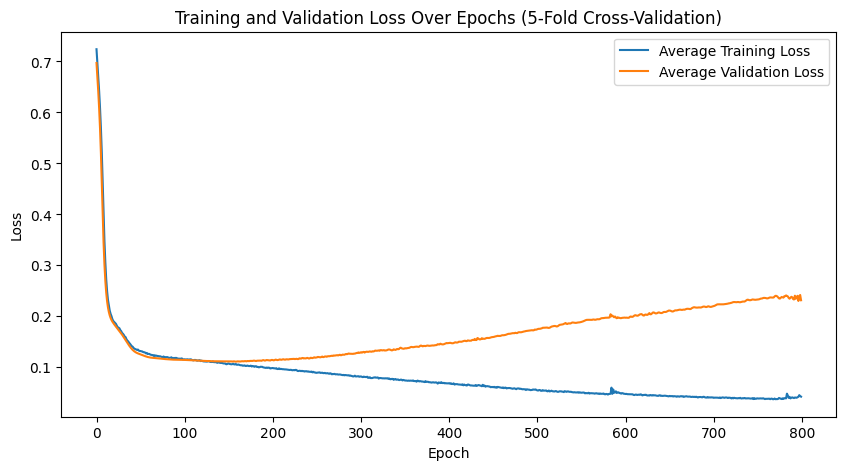

In [168]:
# Initialize lists to store results for all metrics across splits
model_results_list = []
allosure_results_list = []
am_results_list = []
log_results_list = []
log_results_list_w = []

# List of thresholds to evaluate
thresholds = np.arange(0.0, 1.02, 0.01)
thresholds_am = np.arange(20, 40, 1)


# Step 2: Set the parameters for the model
input_size = padded_sequences.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
output_size = 1  # Predicting a single value
num_layers = 1  # Number of LSTM layers
num_epochs = 800

# Set up the optimizer and loss function (we'll reset the optimizer for each fold)
criterion = nn.BCEWithLogitsLoss(reduction='none')


# Initialize KFold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Store losses for all folds
fold_train_losses = []
fold_val_losses = []

data_truncated = data_truncated.loc[(data_truncated["label"] != -1) & (data_truncated["label"] != -99)]

# Step 3: Start the 5-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(padded_sequences,strat_labels)):
    print(f"\n--- Fold {fold + 1} ---")

    # Initialize the model once (fixed initialization)
    model = LSTMModel(input_size, hidden_size, output_size, num_layers)

    # Reset the optimizer for each fold (but keep the same model parameters)
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

    # Split data into training and validation sets
    train_sequences, val_sequences = padded_sequences[train_index], padded_sequences[val_index]
    train_labels, val_labels = padded_labels[train_index], padded_labels[val_index]
    train_mask, val_mask = valid_mask[train_index], valid_mask[val_index]
    train_val_ids, val_ids = usubjids[train_index], usubjids[val_index]

#     # ------------------------------
#     #  Oversample the minority group 10x
#     # ------------------------------
#     # Identify the minority samples: sequences whose labels contain at least one '1'
#     minority_indices = []
#     for i in range(len(train_labels)):
#         # Check if there's a '1' anywhere in train_labels[i]
#         if 1 in train_labels[i]:
#             minority_indices.append(i)

#     replication_factor = 5  # replicate minority group 10 times

#     if len(minority_indices) > 0:
#         # Replicate each minority sample 10 times and append
#         train_sequences = np.concatenate(
#             [
#                 train_sequences,
#                 np.repeat(train_sequences[minority_indices], replication_factor, axis=0),
#             ],
#             axis=0
#         )
#         train_labels = np.concatenate(
#             [
#                 train_labels,
#                 np.repeat(train_labels[minority_indices], replication_factor, axis=0),
#             ],
#             axis=0
#         )
#         train_mask = np.concatenate(
#             [
#                 train_mask,
#                 np.repeat(train_mask[minority_indices], replication_factor, axis=0),
#             ],
#             axis=0
#         )
#         train_val_ids = np.concatenate(
#             [
#                 train_val_ids,
#                 np.repeat(train_val_ids[minority_indices], replication_factor, axis=0),
#             ],
#             axis=0
#         )
#     train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
#     train_labels    = torch.tensor(train_labels,    dtype=torch.float32)
#     train_mask      = torch.tensor(train_mask,      dtype=torch.float32)

#     train_sequences, train_labels, train_mask, train_val_ids = shuffle(
#     train_sequences,
#     train_labels,
#     train_mask,
#     train_val_ids,
#     random_state=42  # for reproducibility
# )




    # Store losses for this fold
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass on training data
        train_outputs = model(train_sequences).squeeze(-1)

        # Calculate the training loss with mask
        train_loss = criterion(train_outputs, train_labels)
        train_loss = train_loss * train_mask  # Apply mask to ignore padded positions
        train_loss = train_loss.sum() / train_mask.sum()  # Average loss over non-padded positions

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # Store the training loss
        train_losses.append(train_loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_sequences).squeeze(-1)
            val_loss = criterion(val_outputs, val_labels)
            val_loss = val_loss * val_mask  # Apply mask to ignore padded positions
            val_loss = val_loss.sum() / val_mask.sum()  # Average loss over non-padded positions

            # Store the validation loss
            val_losses.append(val_loss.item())

        # Print epoch losses for this fold
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}')

    # Evaluate model performance on the test dataset for all thresholds
    for threshold in thresholds:
        model_result = evaluate_performance(val_sequences, val_labels, val_mask, threshold)
        model_result['Split'] = fold
        model_results_list.append(model_result)
    
    # Evaluate AlloSure performance
    test_dataset = data_truncated.loc[data_truncated["usubjid"].isin(val_ids)]
    for threshold in thresholds:
        allosure_result = evaluate_allosure_performance(test_dataset, threshold)
        allosure_result['Split'] = fold
        allosure_results_list.append(allosure_result)

    # Evaluate AlloMap performance
    test_dataset = data_truncated.loc[data_truncated["usubjid"].isin(val_ids)]
    for threshold in thresholds_am:
        am_result = evaluate_allomap_performance(test_dataset, threshold)
        am_result['Split'] = fold
        am_results_list.append(am_result)

    feature = ['aval_AlloMap', 'aval_AlloSure']
    for threshold in thresholds:
        lg_result = evaluation_logistic_regression(best_model, test_dataset, threshold)
        lg_result['Split'] = fold
        log_results_list.append(lg_result)

    # Evaluate logistic model with rejection
    feature = ['aval_AlloMap', 'aval_AlloSure', "prev_label"]
    for threshold in thresholds:
        lg_result = evaluation_logistic_regression(best_model_w, test_dataset, threshold)
        lg_result['Split'] = fold
        log_results_list_w.append(lg_result)
        
    # Store fold losses for analysis later
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)

# Step 4: Calculate average losses across all folds
avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)

# Convert lists of results to DataFrames for easier calculations
model_results_df = pd.DataFrame(model_results_list)
allosure_results_df = pd.DataFrame(allosure_results_list)
am_results_df = pd.DataFrame(am_results_list)
lg_results_df = pd.DataFrame(log_results_list)
lg_results_w_df = pd.DataFrame(log_results_list_w)

# Add a column to indicate the evaluation method
model_results_df['Evaluation Method'] = 'Model'
allosure_results_df['Evaluation Method'] = 'AlloSure'
lg_results_df["Evaluation Method"] = 'Logistic Regression'
lg_results_w_df["Evaluation Method"] = 'Logistic Regression w/ rej'
am_results_df["Evaluation Method"] = "AlloMap"

# Aggregate metrics for both model performance and AlloSure performance
aggregated_model_results = aggregate_metrics_formatted(model_results_df)
aggregated_allosure_results = aggregate_metrics_formatted(allosure_results_df)
aggregated_am_results = aggregate_metrics_formatted(am_results_df)
aggregated_lg_results = aggregate_metrics_formatted(lg_results_df)
aggregated_lg_w_results = aggregate_metrics_formatted(lg_results_w_df)


# Add a new column 'Source' to each DataFrame to track where the results are coming from
aggregated_model_results['Source'] = 'Model'
aggregated_allosure_results['Source'] = 'AlloSure'
aggregated_am_results['Source'] = 'AlloMap'
aggregated_lg_results["Source"] = "Logistic Regression"
aggregated_lg_w_results["Source"] = "Logistic Regression w/ rej"

# Concatenate vertically (stacking)
concatenated_results_vertical = pd.concat([aggregated_model_results, aggregated_allosure_results, aggregated_am_results, aggregated_lg_results, aggregated_lg_w_results], axis=0)


# Step 5: Plot the average Training and Validation Losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Average Training Loss')
plt.plot(avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (5-Fold Cross-Validation)')
plt.legend()
plt.show()

In [169]:
concatenated_results_vertical["AUC"].unique()

array(['0.578 (0.547, 0.547)', '0.662 (0.640, 0.640)',
       '0.594 (0.565, 0.565)', '0.643 (0.628, 0.628)',
       '0.675 (0.657, 0.657)'], dtype=object)

In [51]:
#Save
concatenated_results_vertical.to_csv("./Outputs/acrandamr_confidence_5folds_rawAS_45days_v2_lgwrj_2to15_f(-1)label_4features_<=infinit_strat(strat_id)_.csv")

# Aggregated 10 times reshuffle plus 5 folds cross validation

### Now you have results from all iterations and folds in the dataframes.
### The 'Iteration' and 'Split' columns can be used to track which iteration and fold each result belongs to.


In [170]:
num_iterations = 10

# Initialize lists to store all results across all iterations and folds
model_results_list = []
allosure_results_list = []
am_results_list = []
log_results_list = []
log_results_list_w = []

# Store losses for all folds and iterations
fold_train_losses = []
fold_val_losses = []

data_truncated = data_truncated.loc[(data_truncated["label"] != -1) & (data_truncated["label"] != -99)]

hidden_size = 64  # You can adjust this
output_size = 1  # Predicting a single value
num_layers = 1  # Number of LSTM layers
num_epochs = 150

# List of thresholds to evaluate
thresholds = np.arange(0.0, 1.02, 0.01)
thresholds_am = np.arange(20, 40, 1)

# Run the entire 5-fold CV process num_iterations times
for iteration in range(num_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    # Create a new KFold cross-validator for each iteration with a different random state
    kf = KFold(n_splits=5, shuffle=True, random_state=42 + iteration)

    # Run 5-fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(padded_sequences, strat_labels)):
        print(f"\n--- Iteration {iteration + 1}, Fold {fold + 1} ---")

        # Initialize the model once (fixed initialization)
        model = LSTMModel(input_size, hidden_size, output_size, num_layers)

        # Reset the optimizer for each fold (but keep the same model parameters)
        optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

        # Split data into training and validation sets
        train_sequences, val_sequences = padded_sequences[train_index], padded_sequences[val_index]
        train_labels, val_labels = padded_labels[train_index], padded_labels[val_index]
        train_mask, val_mask = valid_mask[train_index], valid_mask[val_index]
        train_val_ids, val_ids = usubjids[train_index], usubjids[val_index]

        # Store losses for this fold
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            model.train()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass on training data
            train_outputs = model(train_sequences).squeeze(-1)

            # Calculate the training loss with mask
            train_loss = criterion(train_outputs, train_labels)
            train_loss = train_loss * train_mask  # Apply mask
            train_loss = train_loss.sum() / train_mask.sum()  # Average over non-padded positions

            # Backward pass and optimization
            train_loss.backward()
            optimizer.step()

            # Store the training loss
            train_losses.append(train_loss.item())

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(val_sequences).squeeze(-1)
                val_loss = criterion(val_outputs, val_labels)
                val_loss = val_loss * val_mask  # Apply mask
                val_loss = val_loss.sum() / val_mask.sum()  # Average over non-padded positions

                # Store the validation loss
                val_losses.append(val_loss.item())

            # Print epoch losses for this fold
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}')

        # Evaluate model performance on the test dataset for all thresholds
        test_dataset = data_truncated.loc[data_truncated["usubjid"].isin(val_ids)]
        for threshold in thresholds:
            model_result = evaluate_performance(val_sequences, val_labels, val_mask, threshold)
            model_result['Split'] = fold
            model_result['Iteration'] = iteration
            model_results_list.append(model_result)

        # Evaluate AlloSure performance
        for threshold in thresholds:
            allosure_result = evaluate_allosure_performance(test_dataset, threshold)
            allosure_result['Split'] = fold
            allosure_result['Iteration'] = iteration
            allosure_results_list.append(allosure_result)

        # Evaluate AlloMap performance
        for threshold in thresholds_am:
            am_result = evaluate_allomap_performance(test_dataset, threshold)
            am_result['Split'] = fold
            am_result['Iteration'] = iteration
            am_results_list.append(am_result)

        # Evaluate logistic model
        train_dataset = data_truncated.loc[data_truncated["usubjid"].isin(train_val_ids)]
        feature = ['aval_AlloMap', 'aval_AlloSure']
        X_train, y_train = extract_features_and_labels(train_dataset)

        # Create logistic regression model using best_params
        best_model = LogisticRegression(
            max_iter=1000, 
            solver='saga', 
            n_jobs=-1, 
            class_weight="balanced",
            **best_params_  # make sure you already have best_params from your global grid search
        )
        # Fit logistic regression on train dataset
        best_model.fit(X_train, y_train)
        for threshold in thresholds:
            lg_result = evaluation_logistic_regression(best_model, test_dataset, threshold)
            lg_result['Split'] = fold
            lg_result['Iteration'] = iteration
            log_results_list.append(lg_result)

        # Evaluate logistic model with rejection
        train_dataset = data_truncated.loc[data_truncated["usubjid"].isin(train_val_ids)]
        feature = ['aval_AlloMap', 'aval_AlloSure', "prev_label"]
        X_train, y_train = extract_features_and_labels(train_dataset)
        # Create logistic regression model using best_params
        best_model = LogisticRegression(
            max_iter=1000, 
            solver='saga', 
            n_jobs=-1, 
            class_weight="balanced",
            **best_params_w  # make sure you already have best_params from your global grid search
        )
        # Fit logistic regression on train dataset
        best_model_w.fit(X_train, y_train)
        for threshold in thresholds:
            lg_result = evaluation_logistic_regression(best_model_w, test_dataset, threshold)
            lg_result['Split'] = fold
            lg_result['Iteration'] = iteration
            log_results_list_w.append(lg_result)

        # Store fold losses
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

# After all iterations and folds are done, aggregate results
avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)

# Convert lists of results to DataFrames
model_results_df = pd.DataFrame(model_results_list)
allosure_results_df = pd.DataFrame(allosure_results_list)
am_results_df = pd.DataFrame(am_results_list)
lg_results_df = pd.DataFrame(log_results_list)
lg_results_w_df = pd.DataFrame(log_results_list_w)

# Add a column to indicate the evaluation method
model_results_df['Evaluation Method'] = 'Model'
allosure_results_df['Evaluation Method'] = 'AlloSure'
lg_results_df["Evaluation Method"] = 'Logistic Regression'
lg_results_w_df["Evaluation Method"] = 'Logistic Regression w/ rej'
am_results_df["Evaluation Method"] = "AlloMap"

# Aggregate metrics
aggregated_model_results = aggregate_metrics_formatted(model_results_df)
aggregated_allosure_results = aggregate_metrics_formatted(allosure_results_df)
aggregated_am_results = aggregate_metrics_formatted(am_results_df)
aggregated_lg_results = aggregate_metrics_formatted(lg_results_df)
aggregated_lg_w_results = aggregate_metrics_formatted(lg_results_w_df)

# Add a new column 'Source' to each DataFrame
aggregated_model_results['Source'] = 'Model'
aggregated_allosure_results['Source'] = 'AlloSure'
aggregated_am_results['Source'] = 'AlloMap'
aggregated_lg_results["Source"] = "Logistic Regression"
aggregated_lg_w_results["Source"] = "Logistic Regression w/ rej"

# Concatenate vertically
concatenated_results_vertical = pd.concat([
    aggregated_model_results, 
    aggregated_allosure_results, 
    aggregated_am_results, 
    aggregated_lg_results, 
    aggregated_lg_w_results
], axis=0)


=== Iteration 1 ===

--- Iteration 1, Fold 1 ---
Epoch 1/150, Train Loss: 0.7475348114967346, Val Loss: 0.7164450883865356
Epoch 2/150, Train Loss: 0.7178553342819214, Val Loss: 0.6855943202972412
Epoch 3/150, Train Loss: 0.6876266598701477, Val Loss: 0.6514314413070679


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 4/150, Train Loss: 0.6529654860496521, Val Loss: 0.6116804480552673
Epoch 5/150, Train Loss: 0.6143662929534912, Val Loss: 0.5632606148719788
Epoch 6/150, Train Loss: 0.5667031407356262, Val Loss: 0.5038886070251465
Epoch 7/150, Train Loss: 0.5078539848327637, Val Loss: 0.43796512484550476
Epoch 8/150, Train Loss: 0.44523265957832336, Val Loss: 0.37767890095710754
Epoch 9/150, Train Loss: 0.3832078278064728, Val Loss: 0.329720675945282
Epoch 10/150, Train Loss: 0.33342695236206055, Val Loss: 0.2936488687992096
Epoch 11/150, Train Loss: 0.29658615589141846, Val Loss: 0.26713117957115173
Epoch 12/150, Train Loss: 0.2671128809452057, Val Loss: 0.24786479771137238
Epoch 13/150, Train Loss: 0.2458765059709549, Val Loss: 0.2339969277381897
Epoch 14/150, Train Loss: 0.22875532507896423, Val Loss: 0.2240467220544815
Epoch 15/150, Train Loss: 0.21559497714042664, Val Loss: 0.21687307953834534
Epoch 16/150, Train Loss: 0.20725436508655548, Val Loss: 0.2116444706916809
Epoch 17/150, Train L

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 1, Fold 2 ---
Epoch 1/150, Train Loss: 0.7492453455924988, Val Loss: 0.7225725054740906
Epoch 2/150, Train Loss: 0.7219434976577759, Val Loss: 0.6956340670585632
Epoch 3/150, Train Loss: 0.6954150795936584, Val Loss: 0.6683810949325562
Epoch 4/150, Train Loss: 0.6692206263542175, Val Loss: 0.639168918132782
Epoch 5/150, Train Loss: 0.641241192817688, Val Loss: 0.6061902642250061
Epoch 6/150, Train Loss: 0.6099656820297241, Val Loss: 0.5669684410095215
Epoch 7/150, Train Loss: 0.5712957382202148, Val Loss: 0.5183347463607788
Epoch 8/150, Train Loss: 0.5260263681411743, Val Loss: 0.45847147703170776
Epoch 9/150, Train Loss: 0.4706178307533264, Val Loss: 0.39352789521217346
Epoch 10/150, Train Loss: 0.4112469255924225, Val Loss: 0.33500465750694275
Epoch 11/150, Train Loss: 0.3573397397994995, Val Loss: 0.28769510984420776
Epoch 12/150, Train Loss: 0.31573912501335144, Val Loss: 0.25097501277923584
Epoch 13/150, Train Loss: 0.28479576110839844, Val Loss: 0.22278563678264618

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 1, Fold 3 ---
Epoch 1/150, Train Loss: 0.6746892333030701, Val Loss: 0.6527834534645081
Epoch 2/150, Train Loss: 0.6517537832260132, Val Loss: 0.6312858462333679
Epoch 3/150, Train Loss: 0.6296689510345459, Val Loss: 0.6091663241386414
Epoch 4/150, Train Loss: 0.6068037152290344, Val Loss: 0.5849425792694092
Epoch 5/150, Train Loss: 0.5821150541305542, Val Loss: 0.5568942427635193
Epoch 6/150, Train Loss: 0.5536129474639893, Val Loss: 0.5228356122970581
Epoch 7/150, Train Loss: 0.5188903212547302, Val Loss: 0.48001331090927124
Epoch 8/150, Train Loss: 0.4751957356929779, Val Loss: 0.42683282494544983
Epoch 9/150, Train Loss: 0.4220026433467865, Val Loss: 0.3702481687068939
Epoch 10/150, Train Loss: 0.364284873008728, Val Loss: 0.32237252593040466
Epoch 11/150, Train Loss: 0.3155874013900757, Val Loss: 0.28633221983909607
Epoch 12/150, Train Loss: 0.27842116355895996, Val Loss: 0.2604950964450836
Epoch 13/150, Train Loss: 0.2475985884666443, Val Loss: 0.24248550832271576


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 1, Fold 4 ---
Epoch 1/150, Train Loss: 0.6506975293159485, Val Loss: 0.6244785785675049
Epoch 2/150, Train Loss: 0.624170184135437, Val Loss: 0.5986538529396057
Epoch 3/150, Train Loss: 0.5977360606193542, Val Loss: 0.570814311504364
Epoch 4/150, Train Loss: 0.5686159729957581, Val Loss: 0.5393804907798767
Epoch 5/150, Train Loss: 0.5363920331001282, Val Loss: 0.502335250377655
Epoch 6/150, Train Loss: 0.49814173579216003, Val Loss: 0.457442969083786
Epoch 7/150, Train Loss: 0.4503798186779022, Val Loss: 0.404837042093277
Epoch 8/150, Train Loss: 0.3958316445350647, Val Loss: 0.3521357476711273
Epoch 9/150, Train Loss: 0.34080103039741516, Val Loss: 0.3083280026912689
Epoch 10/150, Train Loss: 0.2963957190513611, Val Loss: 0.27476274967193604
Epoch 11/150, Train Loss: 0.2633744478225708, Val Loss: 0.24957361817359924
Epoch 12/150, Train Loss: 0.24041755497455597, Val Loss: 0.230921670794487
Epoch 13/150, Train Loss: 0.22544588148593903, Val Loss: 0.21725165843963623
Epoc

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 1, Fold 5 ---
Epoch 1/150, Train Loss: 0.6908486485481262, Val Loss: 0.6646553874015808
Epoch 2/150, Train Loss: 0.6653344035148621, Val Loss: 0.6395617127418518
Epoch 3/150, Train Loss: 0.6407595276832581, Val Loss: 0.6143479943275452
Epoch 4/150, Train Loss: 0.616130530834198, Val Loss: 0.587385356426239
Epoch 5/150, Train Loss: 0.5902300477027893, Val Loss: 0.5568031072616577
Epoch 6/150, Train Loss: 0.560099184513092, Val Loss: 0.5204092264175415
Epoch 7/150, Train Loss: 0.5253059267997742, Val Loss: 0.4758388102054596
Epoch 8/150, Train Loss: 0.48261892795562744, Val Loss: 0.4224497377872467
Epoch 9/150, Train Loss: 0.43103742599487305, Val Loss: 0.3661271035671234
Epoch 10/150, Train Loss: 0.3747453987598419, Val Loss: 0.3168153464794159
Epoch 11/150, Train Loss: 0.32705777883529663, Val Loss: 0.2786327004432678
Epoch 12/150, Train Loss: 0.29071539640426636, Val Loss: 0.2507556080818176
Epoch 13/150, Train Loss: 0.2588362693786621, Val Loss: 0.2310141921043396
Epoc

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 2 ===

--- Iteration 2, Fold 1 ---
Epoch 1/150, Train Loss: 0.744263231754303, Val Loss: 0.7140390872955322
Epoch 2/150, Train Loss: 0.7137764692306519, Val Loss: 0.6840874552726746
Epoch 3/150, Train Loss: 0.6846776604652405, Val Loss: 0.6534928679466248
Epoch 4/150, Train Loss: 0.6542323231697083, Val Loss: 0.620261013507843
Epoch 5/150, Train Loss: 0.620810329914093, Val Loss: 0.5821318030357361
Epoch 6/150, Train Loss: 0.5837107300758362, Val Loss: 0.5365809798240662
Epoch 7/150, Train Loss: 0.5395399332046509, Val Loss: 0.481430321931839
Epoch 8/150, Train Loss: 0.48618897795677185, Val Loss: 0.41832277178764343
Epoch 9/150, Train Loss: 0.4259386360645294, Val Loss: 0.3576347231864929
Epoch 10/150, Train Loss: 0.36860373616218567, Val Loss: 0.3086318373680115
Epoch 11/150, Train Loss: 0.3212277591228485, Val Loss: 0.2715994119644165
Epoch 12/150, Train Loss: 0.28535225987434387, Val Loss: 0.24411694705486298
Epoch 13/150, Train Loss: 0.25911253690719604, Val Loss: 0

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 2, Fold 2 ---
Epoch 1/150, Train Loss: 0.6552899479866028, Val Loss: 0.630178689956665
Epoch 2/150, Train Loss: 0.6312995553016663, Val Loss: 0.6069747805595398
Epoch 3/150, Train Loss: 0.6077708601951599, Val Loss: 0.583063006401062
Epoch 4/150, Train Loss: 0.5837342143058777, Val Loss: 0.5568878054618835
Epoch 5/150, Train Loss: 0.5586897134780884, Val Loss: 0.5266240835189819
Epoch 6/150, Train Loss: 0.5285429358482361, Val Loss: 0.49001091718673706
Epoch 7/150, Train Loss: 0.4919035732746124, Val Loss: 0.44464102387428284
Epoch 8/150, Train Loss: 0.44735756516456604, Val Loss: 0.39109283685684204
Epoch 9/150, Train Loss: 0.394758015871048, Val Loss: 0.33807605504989624
Epoch 10/150, Train Loss: 0.3409605324268341, Val Loss: 0.2943282723426819
Epoch 11/150, Train Loss: 0.29694071412086487, Val Loss: 0.2612279951572418
Epoch 12/150, Train Loss: 0.2641708552837372, Val Loss: 0.2368340641260147
Epoch 13/150, Train Loss: 0.23852083086967468, Val Loss: 0.21896876394748688


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 2, Fold 3 ---
Epoch 1/150, Train Loss: 0.7183253765106201, Val Loss: 0.6943385601043701
Epoch 2/150, Train Loss: 0.6944625377655029, Val Loss: 0.6719433069229126
Epoch 3/150, Train Loss: 0.6717805862426758, Val Loss: 0.6496047377586365
Epoch 4/150, Train Loss: 0.6493534445762634, Val Loss: 0.625896692276001
Epoch 5/150, Train Loss: 0.625424861907959, Val Loss: 0.5992634892463684
Epoch 6/150, Train Loss: 0.5994077920913696, Val Loss: 0.5678300857543945
Epoch 7/150, Train Loss: 0.5686528086662292, Val Loss: 0.5291217565536499
Epoch 8/150, Train Loss: 0.5317750573158264, Val Loss: 0.4808937609195709
Epoch 9/150, Train Loss: 0.4858238995075226, Val Loss: 0.4254489541053772
Epoch 10/150, Train Loss: 0.4319567084312439, Val Loss: 0.37163883447647095
Epoch 11/150, Train Loss: 0.38128751516342163, Val Loss: 0.3262064456939697
Epoch 12/150, Train Loss: 0.33707964420318604, Val Loss: 0.29082587361335754
Epoch 13/150, Train Loss: 0.29877495765686035, Val Loss: 0.26462793350219727
E

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 2, Fold 4 ---
Epoch 1/150, Train Loss: 0.710374653339386, Val Loss: 0.6840059161186218
Epoch 2/150, Train Loss: 0.6843043565750122, Val Loss: 0.6580211520195007
Epoch 3/150, Train Loss: 0.6585750579833984, Val Loss: 0.6308084726333618
Epoch 4/150, Train Loss: 0.6315579414367676, Val Loss: 0.6008201837539673
Epoch 5/150, Train Loss: 0.6008799076080322, Val Loss: 0.5657699704170227
Epoch 6/150, Train Loss: 0.5670741200447083, Val Loss: 0.522675096988678
Epoch 7/150, Train Loss: 0.5236834287643433, Val Loss: 0.4694734811782837
Epoch 8/150, Train Loss: 0.46858400106430054, Val Loss: 0.4105224609375
Epoch 9/150, Train Loss: 0.4083273410797119, Val Loss: 0.3564152121543884
Epoch 10/150, Train Loss: 0.35609275102615356, Val Loss: 0.312274307012558
Epoch 11/150, Train Loss: 0.31093916296958923, Val Loss: 0.2780497372150421
Epoch 12/150, Train Loss: 0.27818769216537476, Val Loss: 0.2522285282611847
Epoch 13/150, Train Loss: 0.2537876069545746, Val Loss: 0.2329561412334442
Epoch 1

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 2, Fold 5 ---
Epoch 1/150, Train Loss: 0.7250135540962219, Val Loss: 0.6978384256362915
Epoch 2/150, Train Loss: 0.6981856822967529, Val Loss: 0.6713188886642456
Epoch 3/150, Train Loss: 0.6720108389854431, Val Loss: 0.6432734131813049
Epoch 4/150, Train Loss: 0.6441346406936646, Val Loss: 0.6118960380554199
Epoch 5/150, Train Loss: 0.6124880909919739, Val Loss: 0.5749685168266296
Epoch 6/150, Train Loss: 0.5740050077438354, Val Loss: 0.5296842455863953
Epoch 7/150, Train Loss: 0.5291426777839661, Val Loss: 0.47408735752105713
Epoch 8/150, Train Loss: 0.47294753789901733, Val Loss: 0.41221919655799866
Epoch 9/150, Train Loss: 0.40996354818344116, Val Loss: 0.35539793968200684
Epoch 10/150, Train Loss: 0.35266169905662537, Val Loss: 0.3103254437446594
Epoch 11/150, Train Loss: 0.3117978870868683, Val Loss: 0.27625447511672974
Epoch 12/150, Train Loss: 0.27748921513557434, Val Loss: 0.2506856918334961
Epoch 13/150, Train Loss: 0.2545953392982483, Val Loss: 0.23160359263420

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 3 ===

--- Iteration 3, Fold 1 ---
Epoch 1/150, Train Loss: 0.642799973487854, Val Loss: 0.6182938814163208
Epoch 2/150, Train Loss: 0.6208564639091492, Val Loss: 0.5934855341911316
Epoch 3/150, Train Loss: 0.5963155627250671, Val Loss: 0.565944254398346
Epoch 4/150, Train Loss: 0.5703853368759155, Val Loss: 0.5336225032806396
Epoch 5/150, Train Loss: 0.5394756197929382, Val Loss: 0.4936785101890564
Epoch 6/150, Train Loss: 0.5020129084587097, Val Loss: 0.4431241750717163
Epoch 7/150, Train Loss: 0.4548053741455078, Val Loss: 0.38343748450279236
Epoch 8/150, Train Loss: 0.39935576915740967, Val Loss: 0.3256203532218933
Epoch 9/150, Train Loss: 0.3458757996559143, Val Loss: 0.2786501348018646
Epoch 10/150, Train Loss: 0.3030380606651306, Val Loss: 0.2432437539100647
Epoch 11/150, Train Loss: 0.270713746547699, Val Loss: 0.21710187196731567
Epoch 12/150, Train Loss: 0.24714750051498413, Val Loss: 0.1977919638156891
Epoch 13/150, Train Loss: 0.23353862762451172, Val Loss: 0

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 3, Fold 2 ---
Epoch 1/150, Train Loss: 0.6276518106460571, Val Loss: 0.6022255420684814
Epoch 2/150, Train Loss: 0.6007770895957947, Val Loss: 0.5736645460128784
Epoch 3/150, Train Loss: 0.5726601481437683, Val Loss: 0.5410498380661011
Epoch 4/150, Train Loss: 0.5388638377189636, Val Loss: 0.5020570755004883
Epoch 5/150, Train Loss: 0.4991212785243988, Val Loss: 0.45436909794807434
Epoch 6/150, Train Loss: 0.4505462348461151, Val Loss: 0.3988678455352783
Epoch 7/150, Train Loss: 0.39353832602500916, Val Loss: 0.34536999464035034
Epoch 8/150, Train Loss: 0.33747053146362305, Val Loss: 0.303192138671875
Epoch 9/150, Train Loss: 0.29474779963493347, Val Loss: 0.27282318472862244
Epoch 10/150, Train Loss: 0.26262935996055603, Val Loss: 0.25161439180374146
Epoch 11/150, Train Loss: 0.23977406322956085, Val Loss: 0.23694884777069092
Epoch 12/150, Train Loss: 0.22376152873039246, Val Loss: 0.22680100798606873
Epoch 13/150, Train Loss: 0.21146927773952484, Val Loss: 0.2197471708

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 3, Fold 3 ---
Epoch 1/150, Train Loss: 0.6845450401306152, Val Loss: 0.6595185995101929
Epoch 2/150, Train Loss: 0.6592723727226257, Val Loss: 0.6356616616249084
Epoch 3/150, Train Loss: 0.6353068947792053, Val Loss: 0.6109979152679443
Epoch 4/150, Train Loss: 0.610267698764801, Val Loss: 0.5838267803192139
Epoch 5/150, Train Loss: 0.5816003680229187, Val Loss: 0.5521256327629089
Epoch 6/150, Train Loss: 0.5495333671569824, Val Loss: 0.513322114944458
Epoch 7/150, Train Loss: 0.5089953541755676, Val Loss: 0.46485576033592224
Epoch 8/150, Train Loss: 0.4597235918045044, Val Loss: 0.4084506332874298
Epoch 9/150, Train Loss: 0.40157726407051086, Val Loss: 0.3553519546985626
Epoch 10/150, Train Loss: 0.3458227813243866, Val Loss: 0.3139408826828003
Epoch 11/150, Train Loss: 0.30175864696502686, Val Loss: 0.28390660881996155
Epoch 12/150, Train Loss: 0.26609256863594055, Val Loss: 0.26263368129730225
Epoch 13/150, Train Loss: 0.24274992942810059, Val Loss: 0.24784278869628906

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 3, Fold 4 ---
Epoch 1/150, Train Loss: 0.7072014808654785, Val Loss: 0.6818285584449768
Epoch 2/150, Train Loss: 0.6820776462554932, Val Loss: 0.6570267677307129
Epoch 3/150, Train Loss: 0.6575882434844971, Val Loss: 0.6309053301811218
Epoch 4/150, Train Loss: 0.632218599319458, Val Loss: 0.6016965508460999
Epoch 5/150, Train Loss: 0.6039004921913147, Val Loss: 0.5671887397766113
Epoch 6/150, Train Loss: 0.5706947445869446, Val Loss: 0.524708092212677
Epoch 7/150, Train Loss: 0.5300782918930054, Val Loss: 0.47179535031318665
Epoch 8/150, Train Loss: 0.4796368479728699, Val Loss: 0.41070225834846497
Epoch 9/150, Train Loss: 0.4223487973213196, Val Loss: 0.3512486219406128
Epoch 10/150, Train Loss: 0.36890819668769836, Val Loss: 0.30110469460487366
Epoch 11/150, Train Loss: 0.3226330876350403, Val Loss: 0.26172491908073425
Epoch 12/150, Train Loss: 0.2875617742538452, Val Loss: 0.23189060389995575
Epoch 13/150, Train Loss: 0.26002037525177, Val Loss: 0.209740549325943
Epoc

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 3, Fold 5 ---
Epoch 1/150, Train Loss: 0.7613654732704163, Val Loss: 0.7364522218704224
Epoch 2/150, Train Loss: 0.7359085083007812, Val Loss: 0.7130208611488342
Epoch 3/150, Train Loss: 0.7126875519752502, Val Loss: 0.689306914806366
Epoch 4/150, Train Loss: 0.6885368227958679, Val Loss: 0.663810670375824
Epoch 5/150, Train Loss: 0.662563145160675, Val Loss: 0.6349607110023499
Epoch 6/150, Train Loss: 0.6326904892921448, Val Loss: 0.6008139252662659
Epoch 7/150, Train Loss: 0.5973711013793945, Val Loss: 0.5589103698730469
Epoch 8/150, Train Loss: 0.5545088648796082, Val Loss: 0.5070531368255615
Epoch 9/150, Train Loss: 0.5026958584785461, Val Loss: 0.4477899968624115
Epoch 10/150, Train Loss: 0.4425663650035858, Val Loss: 0.3907703757286072
Epoch 11/150, Train Loss: 0.3844790756702423, Val Loss: 0.343167781829834
Epoch 12/150, Train Loss: 0.33685335516929626, Val Loss: 0.30606481432914734
Epoch 13/150, Train Loss: 0.29816561937332153, Val Loss: 0.27802902460098267
Epoch

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 4 ===

--- Iteration 4, Fold 1 ---
Epoch 1/150, Train Loss: 0.699932873249054, Val Loss: 0.6739340424537659
Epoch 2/150, Train Loss: 0.6736489534378052, Val Loss: 0.6475986838340759
Epoch 3/150, Train Loss: 0.6466912627220154, Val Loss: 0.6184510588645935
Epoch 4/150, Train Loss: 0.6179143786430359, Val Loss: 0.584069013595581
Epoch 5/150, Train Loss: 0.5830099582672119, Val Loss: 0.5414819717407227
Epoch 6/150, Train Loss: 0.5393621921539307, Val Loss: 0.4877164661884308
Epoch 7/150, Train Loss: 0.48465317487716675, Val Loss: 0.4249124228954315
Epoch 8/150, Train Loss: 0.42104101181030273, Val Loss: 0.3657231032848358
Epoch 9/150, Train Loss: 0.3613717257976532, Val Loss: 0.31884539127349854
Epoch 10/150, Train Loss: 0.3136689364910126, Val Loss: 0.28451836109161377
Epoch 11/150, Train Loss: 0.27879852056503296, Val Loss: 0.26021862030029297
Epoch 12/150, Train Loss: 0.25382566452026367, Val Loss: 0.24315917491912842
Epoch 13/150, Train Loss: 0.23322142660617828, Val Lo

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 4, Fold 2 ---
Epoch 1/150, Train Loss: 0.7139701843261719, Val Loss: 0.689195990562439
Epoch 2/150, Train Loss: 0.6893494725227356, Val Loss: 0.665576159954071
Epoch 3/150, Train Loss: 0.6655208468437195, Val Loss: 0.6411232352256775
Epoch 4/150, Train Loss: 0.6417168378829956, Val Loss: 0.6141108274459839
Epoch 5/150, Train Loss: 0.6153396368026733, Val Loss: 0.5826465487480164
Epoch 6/150, Train Loss: 0.5842267870903015, Val Loss: 0.5444785952568054
Epoch 7/150, Train Loss: 0.5460537075996399, Val Loss: 0.4971107542514801
Epoch 8/150, Train Loss: 0.5006269812583923, Val Loss: 0.44043874740600586
Epoch 9/150, Train Loss: 0.44622287154197693, Val Loss: 0.3817427456378937
Epoch 10/150, Train Loss: 0.39147359132766724, Val Loss: 0.3301997780799866
Epoch 11/150, Train Loss: 0.3427949547767639, Val Loss: 0.2888976037502289
Epoch 12/150, Train Loss: 0.30310332775115967, Val Loss: 0.2570679783821106
Epoch 13/150, Train Loss: 0.2720490097999573, Val Loss: 0.23305337131023407
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 4, Fold 3 ---
Epoch 1/150, Train Loss: 0.6998093128204346, Val Loss: 0.6709091067314148
Epoch 2/150, Train Loss: 0.670790433883667, Val Loss: 0.64133620262146
Epoch 3/150, Train Loss: 0.6407155394554138, Val Loss: 0.6097397804260254
Epoch 4/150, Train Loss: 0.6076787710189819, Val Loss: 0.5742217898368835
Epoch 5/150, Train Loss: 0.5721396803855896, Val Loss: 0.5325585603713989
Epoch 6/150, Train Loss: 0.5300737619400024, Val Loss: 0.48250582814216614
Epoch 7/150, Train Loss: 0.4783947765827179, Val Loss: 0.4247283637523651
Epoch 8/150, Train Loss: 0.4209209084510803, Val Loss: 0.3676912784576416
Epoch 9/150, Train Loss: 0.363350510597229, Val Loss: 0.32093003392219543
Epoch 10/150, Train Loss: 0.31586772203445435, Val Loss: 0.2863372266292572
Epoch 11/150, Train Loss: 0.28095313906669617, Val Loss: 0.26178500056266785
Epoch 12/150, Train Loss: 0.251966655254364, Val Loss: 0.24465671181678772
Epoch 13/150, Train Loss: 0.23289616405963898, Val Loss: 0.23277805745601654
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 4, Fold 4 ---
Epoch 1/150, Train Loss: 0.679770290851593, Val Loss: 0.6532644033432007
Epoch 2/150, Train Loss: 0.652550220489502, Val Loss: 0.6260210275650024
Epoch 3/150, Train Loss: 0.6252047419548035, Val Loss: 0.5967127084732056
Epoch 4/150, Train Loss: 0.5958238840103149, Val Loss: 0.5633401274681091
Epoch 5/150, Train Loss: 0.5622273087501526, Val Loss: 0.5232861042022705
Epoch 6/150, Train Loss: 0.5225339531898499, Val Loss: 0.47383931279182434
Epoch 7/150, Train Loss: 0.4724295735359192, Val Loss: 0.41583725810050964
Epoch 8/150, Train Loss: 0.4163776636123657, Val Loss: 0.3588102459907532
Epoch 9/150, Train Loss: 0.3595079481601715, Val Loss: 0.31109416484832764
Epoch 10/150, Train Loss: 0.3144802153110504, Val Loss: 0.2735534608364105
Epoch 11/150, Train Loss: 0.27979105710983276, Val Loss: 0.24479107558727264
Epoch 12/150, Train Loss: 0.2527512311935425, Val Loss: 0.22316330671310425
Epoch 13/150, Train Loss: 0.2348848283290863, Val Loss: 0.20710301399230957


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 4, Fold 5 ---
Epoch 1/150, Train Loss: 0.7221441268920898, Val Loss: 0.6997050046920776
Epoch 2/150, Train Loss: 0.7002560496330261, Val Loss: 0.6775708794593811
Epoch 3/150, Train Loss: 0.678118884563446, Val Loss: 0.6543686389923096
Epoch 4/150, Train Loss: 0.6557769775390625, Val Loss: 0.628408670425415
Epoch 5/150, Train Loss: 0.629784882068634, Val Loss: 0.5978363156318665
Epoch 6/150, Train Loss: 0.5999184846878052, Val Loss: 0.5601088404655457
Epoch 7/150, Train Loss: 0.563204824924469, Val Loss: 0.5119945406913757
Epoch 8/150, Train Loss: 0.5175718665122986, Val Loss: 0.45273324847221375
Epoch 9/150, Train Loss: 0.46047157049179077, Val Loss: 0.3907102048397064
Epoch 10/150, Train Loss: 0.40146902203559875, Val Loss: 0.3368547260761261
Epoch 11/150, Train Loss: 0.34735628962516785, Val Loss: 0.2946566641330719
Epoch 12/150, Train Loss: 0.30606338381767273, Val Loss: 0.2630546987056732
Epoch 13/150, Train Loss: 0.2787187993526459, Val Loss: 0.23988677561283112
Epo

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 5 ===

--- Iteration 5, Fold 1 ---
Epoch 1/150, Train Loss: 0.6607582569122314, Val Loss: 0.6350392699241638
Epoch 2/150, Train Loss: 0.6358676552772522, Val Loss: 0.6112603545188904
Epoch 3/150, Train Loss: 0.6118078827857971, Val Loss: 0.5867010951042175
Epoch 4/150, Train Loss: 0.5874289274215698, Val Loss: 0.5598155856132507
Epoch 5/150, Train Loss: 0.56026691198349, Val Loss: 0.5288745760917664
Epoch 6/150, Train Loss: 0.5288248062133789, Val Loss: 0.4918228089809418
Epoch 7/150, Train Loss: 0.4907163977622986, Val Loss: 0.4465639591217041
Epoch 8/150, Train Loss: 0.4435412585735321, Val Loss: 0.3937116861343384
Epoch 9/150, Train Loss: 0.3883683979511261, Val Loss: 0.34062227606773376
Epoch 10/150, Train Loss: 0.3369789123535156, Val Loss: 0.29474470019340515
Epoch 11/150, Train Loss: 0.29561886191368103, Val Loss: 0.25796446204185486
Epoch 12/150, Train Loss: 0.2650708854198456, Val Loss: 0.2293907105922699
Epoch 13/150, Train Loss: 0.24189646542072296, Val Loss: 

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 5, Fold 2 ---
Epoch 1/150, Train Loss: 0.7397112846374512, Val Loss: 0.7108672261238098
Epoch 2/150, Train Loss: 0.7129342555999756, Val Loss: 0.683467447757721
Epoch 3/150, Train Loss: 0.6857074499130249, Val Loss: 0.6539223790168762
Epoch 4/150, Train Loss: 0.6562146544456482, Val Loss: 0.6204029321670532
Epoch 5/150, Train Loss: 0.6229424476623535, Val Loss: 0.5805061459541321
Epoch 6/150, Train Loss: 0.583283007144928, Val Loss: 0.5312058925628662
Epoch 7/150, Train Loss: 0.5359878540039062, Val Loss: 0.4712991714477539
Epoch 8/150, Train Loss: 0.47868478298187256, Val Loss: 0.4093804955482483
Epoch 9/150, Train Loss: 0.4180833101272583, Val Loss: 0.358401358127594
Epoch 10/150, Train Loss: 0.3631933331489563, Val Loss: 0.321294367313385
Epoch 11/150, Train Loss: 0.3158091604709625, Val Loss: 0.29543960094451904
Epoch 12/150, Train Loss: 0.2826223373413086, Val Loss: 0.27791208028793335
Epoch 13/150, Train Loss: 0.25456884503364563, Val Loss: 0.2664231061935425
Epoch

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 5, Fold 3 ---
Epoch 1/150, Train Loss: 0.6476497650146484, Val Loss: 0.6173721551895142
Epoch 2/150, Train Loss: 0.6191559433937073, Val Loss: 0.5882806181907654
Epoch 3/150, Train Loss: 0.5911693572998047, Val Loss: 0.5580345988273621
Epoch 4/150, Train Loss: 0.561837911605835, Val Loss: 0.5251724123954773
Epoch 5/150, Train Loss: 0.5304418802261353, Val Loss: 0.48822978138923645
Epoch 6/150, Train Loss: 0.4946123957633972, Val Loss: 0.44558197259902954
Epoch 7/150, Train Loss: 0.4545202851295471, Val Loss: 0.39644044637680054
Epoch 8/150, Train Loss: 0.4094145894050598, Val Loss: 0.3443286716938019
Epoch 9/150, Train Loss: 0.3619472086429596, Val Loss: 0.2968601584434509
Epoch 10/150, Train Loss: 0.32023805379867554, Val Loss: 0.2580423653125763
Epoch 11/150, Train Loss: 0.2844015657901764, Val Loss: 0.22755175828933716
Epoch 12/150, Train Loss: 0.2598409652709961, Val Loss: 0.20398792624473572
Epoch 13/150, Train Loss: 0.24134910106658936, Val Loss: 0.1859505325555801

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 5, Fold 4 ---
Epoch 1/150, Train Loss: 0.7469720244407654, Val Loss: 0.7169551253318787
Epoch 2/150, Train Loss: 0.7172220945358276, Val Loss: 0.6879076361656189
Epoch 3/150, Train Loss: 0.6876809000968933, Val Loss: 0.6585701107978821
Epoch 4/150, Train Loss: 0.6591368913650513, Val Loss: 0.6275072693824768
Epoch 5/150, Train Loss: 0.6277503371238708, Val Loss: 0.5929228663444519
Epoch 6/150, Train Loss: 0.5944746136665344, Val Loss: 0.5525001287460327
Epoch 7/150, Train Loss: 0.5537089109420776, Val Loss: 0.5036051869392395
Epoch 8/150, Train Loss: 0.504837155342102, Val Loss: 0.4456363320350647
Epoch 9/150, Train Loss: 0.44639405608177185, Val Loss: 0.3855140805244446
Epoch 10/150, Train Loss: 0.3898465037345886, Val Loss: 0.33300426602363586
Epoch 11/150, Train Loss: 0.34162065386772156, Val Loss: 0.290902704000473
Epoch 12/150, Train Loss: 0.30192866921424866, Val Loss: 0.258154958486557
Epoch 13/150, Train Loss: 0.2718351483345032, Val Loss: 0.23299820721149445
Epo

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 5, Fold 5 ---
Epoch 1/150, Train Loss: 0.7348368167877197, Val Loss: 0.7085579633712769
Epoch 2/150, Train Loss: 0.7088893055915833, Val Loss: 0.6834487915039062
Epoch 3/150, Train Loss: 0.6833099722862244, Val Loss: 0.6570452451705933
Epoch 4/150, Train Loss: 0.6562460064888, Val Loss: 0.6278707981109619
Epoch 5/150, Train Loss: 0.6264883279800415, Val Loss: 0.5941652655601501
Epoch 6/150, Train Loss: 0.5926528573036194, Val Loss: 0.5534422993659973
Epoch 7/150, Train Loss: 0.5505498647689819, Val Loss: 0.5027642846107483
Epoch 8/150, Train Loss: 0.500090479850769, Val Loss: 0.4427303671836853
Epoch 9/150, Train Loss: 0.4396362006664276, Val Loss: 0.38342687487602234
Epoch 10/150, Train Loss: 0.37999147176742554, Val Loss: 0.3348428010940552
Epoch 11/150, Train Loss: 0.32971176505088806, Val Loss: 0.2986820936203003
Epoch 12/150, Train Loss: 0.29096364974975586, Val Loss: 0.27283546328544617
Epoch 13/150, Train Loss: 0.2606053948402405, Val Loss: 0.2548380196094513
Epoc

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 6 ===

--- Iteration 6, Fold 1 ---
Epoch 1/150, Train Loss: 0.714557945728302, Val Loss: 0.6868218779563904
Epoch 2/150, Train Loss: 0.6871069073677063, Val Loss: 0.6596938371658325
Epoch 3/150, Train Loss: 0.6601696014404297, Val Loss: 0.6314153671264648
Epoch 4/150, Train Loss: 0.632440447807312, Val Loss: 0.6002417206764221
Epoch 5/150, Train Loss: 0.6011499762535095, Val Loss: 0.5642455220222473
Epoch 6/150, Train Loss: 0.5653724074363708, Val Loss: 0.5210664868354797
Epoch 7/150, Train Loss: 0.5228798985481262, Val Loss: 0.4686111807823181
Epoch 8/150, Train Loss: 0.47182750701904297, Val Loss: 0.4085719883441925
Epoch 9/150, Train Loss: 0.413565069437027, Val Loss: 0.3503112494945526
Epoch 10/150, Train Loss: 0.3572447597980499, Val Loss: 0.3022299110889435
Epoch 11/150, Train Loss: 0.31274911761283875, Val Loss: 0.2649359703063965
Epoch 12/150, Train Loss: 0.27805042266845703, Val Loss: 0.2362755835056305
Epoch 13/150, Train Loss: 0.2529681324958801, Val Loss: 0.2

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 6, Fold 2 ---
Epoch 1/150, Train Loss: 0.7122135758399963, Val Loss: 0.6846985816955566
Epoch 2/150, Train Loss: 0.6850531697273254, Val Loss: 0.6574099063873291
Epoch 3/150, Train Loss: 0.6582167744636536, Val Loss: 0.6281341910362244
Epoch 4/150, Train Loss: 0.6280049085617065, Val Loss: 0.5947005152702332
Epoch 5/150, Train Loss: 0.5944834351539612, Val Loss: 0.5542815327644348
Epoch 6/150, Train Loss: 0.555858850479126, Val Loss: 0.5038715600967407
Epoch 7/150, Train Loss: 0.5057445168495178, Val Loss: 0.44356292486190796
Epoch 8/150, Train Loss: 0.4467746913433075, Val Loss: 0.381747305393219
Epoch 9/150, Train Loss: 0.38866204023361206, Val Loss: 0.32906797528266907
Epoch 10/150, Train Loss: 0.33634352684020996, Val Loss: 0.2891136705875397
Epoch 11/150, Train Loss: 0.29695501923561096, Val Loss: 0.260508269071579
Epoch 12/150, Train Loss: 0.26630762219429016, Val Loss: 0.24070896208286285
Epoch 13/150, Train Loss: 0.24382781982421875, Val Loss: 0.22728750109672546

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 6, Fold 3 ---
Epoch 1/150, Train Loss: 0.7189049124717712, Val Loss: 0.6917732954025269
Epoch 2/150, Train Loss: 0.6925392746925354, Val Loss: 0.6647518277168274
Epoch 3/150, Train Loss: 0.664768397808075, Val Loss: 0.6352391839027405
Epoch 4/150, Train Loss: 0.6347547769546509, Val Loss: 0.6011447906494141
Epoch 5/150, Train Loss: 0.5999842286109924, Val Loss: 0.5598962306976318
Epoch 6/150, Train Loss: 0.5566949248313904, Val Loss: 0.5091425180435181
Epoch 7/150, Train Loss: 0.5040343999862671, Val Loss: 0.45078980922698975
Epoch 8/150, Train Loss: 0.44327396154403687, Val Loss: 0.3940431773662567
Epoch 9/150, Train Loss: 0.38283711671829224, Val Loss: 0.34611785411834717
Epoch 10/150, Train Loss: 0.3348802328109741, Val Loss: 0.3084505796432495
Epoch 11/150, Train Loss: 0.29809993505477905, Val Loss: 0.279840350151062
Epoch 12/150, Train Loss: 0.26940783858299255, Val Loss: 0.2584857642650604
Epoch 13/150, Train Loss: 0.2499927133321762, Val Loss: 0.2427293211221695
E

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 6, Fold 4 ---
Epoch 1/150, Train Loss: 0.64836585521698, Val Loss: 0.6211713552474976
Epoch 2/150, Train Loss: 0.6224979162216187, Val Loss: 0.5924763679504395
Epoch 3/150, Train Loss: 0.594053328037262, Val Loss: 0.5602096319198608
Epoch 4/150, Train Loss: 0.5623123049736023, Val Loss: 0.5223718285560608
Epoch 5/150, Train Loss: 0.5261172652244568, Val Loss: 0.476376473903656
Epoch 6/150, Train Loss: 0.48284122347831726, Val Loss: 0.4204989969730377
Epoch 7/150, Train Loss: 0.4298981726169586, Val Loss: 0.3603868782520294
Epoch 8/150, Train Loss: 0.3729289174079895, Val Loss: 0.30833566188812256
Epoch 9/150, Train Loss: 0.32405731081962585, Val Loss: 0.26896408200263977
Epoch 10/150, Train Loss: 0.2859674096107483, Val Loss: 0.2404044270515442
Epoch 11/150, Train Loss: 0.2572092115879059, Val Loss: 0.21992464363574982
Epoch 12/150, Train Loss: 0.23596273362636566, Val Loss: 0.20528586208820343
Epoch 13/150, Train Loss: 0.220353364944458, Val Loss: 0.19478516280651093
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 6, Fold 5 ---
Epoch 1/150, Train Loss: 0.6348260045051575, Val Loss: 0.6097264885902405
Epoch 2/150, Train Loss: 0.6093583106994629, Val Loss: 0.5832335352897644
Epoch 3/150, Train Loss: 0.5815363526344299, Val Loss: 0.5546190738677979
Epoch 4/150, Train Loss: 0.5522282123565674, Val Loss: 0.5219082832336426
Epoch 5/150, Train Loss: 0.5203726887702942, Val Loss: 0.482785165309906
Epoch 6/150, Train Loss: 0.48133584856987, Val Loss: 0.43550121784210205
Epoch 7/150, Train Loss: 0.4337802827358246, Val Loss: 0.3824107348918915
Epoch 8/150, Train Loss: 0.3797796964645386, Val Loss: 0.33290573954582214
Epoch 9/150, Train Loss: 0.32985830307006836, Val Loss: 0.29400354623794556
Epoch 10/150, Train Loss: 0.28903675079345703, Val Loss: 0.26578086614608765
Epoch 11/150, Train Loss: 0.25780928134918213, Val Loss: 0.2458917498588562
Epoch 12/150, Train Loss: 0.23601874709129333, Val Loss: 0.23199743032455444
Epoch 13/150, Train Loss: 0.21932676434516907, Val Loss: 0.222238734364509

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 7 ===

--- Iteration 7, Fold 1 ---
Epoch 1/150, Train Loss: 0.6993404030799866, Val Loss: 0.6711922287940979
Epoch 2/150, Train Loss: 0.672156572341919, Val Loss: 0.6421903967857361
Epoch 3/150, Train Loss: 0.6435108184814453, Val Loss: 0.6105329990386963
Epoch 4/150, Train Loss: 0.6128675937652588, Val Loss: 0.5741866827011108
Epoch 5/150, Train Loss: 0.5781411528587341, Val Loss: 0.5305261611938477
Epoch 6/150, Train Loss: 0.5358341336250305, Val Loss: 0.47691401839256287
Epoch 7/150, Train Loss: 0.48471418023109436, Val Loss: 0.4152655303478241
Epoch 8/150, Train Loss: 0.4258092939853668, Val Loss: 0.3565773069858551
Epoch 9/150, Train Loss: 0.36978280544281006, Val Loss: 0.3095385730266571
Epoch 10/150, Train Loss: 0.3226411044597626, Val Loss: 0.27466508746147156
Epoch 11/150, Train Loss: 0.2868072986602783, Val Loss: 0.24962303042411804
Epoch 12/150, Train Loss: 0.2606382668018341, Val Loss: 0.2318650782108307
Epoch 13/150, Train Loss: 0.2413163185119629, Val Loss:

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 7, Fold 2 ---
Epoch 1/150, Train Loss: 0.7464743256568909, Val Loss: 0.7167802453041077
Epoch 2/150, Train Loss: 0.7174739837646484, Val Loss: 0.6867185235023499
Epoch 3/150, Train Loss: 0.6878642439842224, Val Loss: 0.6539814472198486
Epoch 4/150, Train Loss: 0.654646098613739, Val Loss: 0.6166425347328186
Epoch 5/150, Train Loss: 0.6180834174156189, Val Loss: 0.5723699331283569
Epoch 6/150, Train Loss: 0.5752342343330383, Val Loss: 0.5183753967285156
Epoch 7/150, Train Loss: 0.5227829217910767, Val Loss: 0.45442259311676025
Epoch 8/150, Train Loss: 0.45975619554519653, Val Loss: 0.3897863030433655
Epoch 9/150, Train Loss: 0.3972497582435608, Val Loss: 0.33601275086402893
Epoch 10/150, Train Loss: 0.34422633051872253, Val Loss: 0.29499146342277527
Epoch 11/150, Train Loss: 0.30424466729164124, Val Loss: 0.2643359899520874
Epoch 12/150, Train Loss: 0.27535805106163025, Val Loss: 0.24161629378795624
Epoch 13/150, Train Loss: 0.25309640169143677, Val Loss: 0.22481560707092

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 7, Fold 3 ---
Epoch 1/150, Train Loss: 0.7848701477050781, Val Loss: 0.7548360228538513
Epoch 2/150, Train Loss: 0.7558836340904236, Val Loss: 0.7280917763710022
Epoch 3/150, Train Loss: 0.728298008441925, Val Loss: 0.7014937996864319
Epoch 4/150, Train Loss: 0.7013647556304932, Val Loss: 0.6734640598297119
Epoch 5/150, Train Loss: 0.672356367111206, Val Loss: 0.6421746611595154
Epoch 6/150, Train Loss: 0.6412263512611389, Val Loss: 0.6053503751754761
Epoch 7/150, Train Loss: 0.603827953338623, Val Loss: 0.5599979162216187
Epoch 8/150, Train Loss: 0.5583938956260681, Val Loss: 0.5033055543899536
Epoch 9/150, Train Loss: 0.5005465149879456, Val Loss: 0.43889087438583374
Epoch 10/150, Train Loss: 0.43845120072364807, Val Loss: 0.37965455651283264
Epoch 11/150, Train Loss: 0.377689003944397, Val Loss: 0.3327382802963257
Epoch 12/150, Train Loss: 0.3316969871520996, Val Loss: 0.29772236943244934
Epoch 13/150, Train Loss: 0.2942405343055725, Val Loss: 0.2720627784729004
Epoch

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 7, Fold 4 ---
Epoch 1/150, Train Loss: 0.647773027420044, Val Loss: 0.6222606897354126
Epoch 2/150, Train Loss: 0.62224280834198, Val Loss: 0.5973824858665466
Epoch 3/150, Train Loss: 0.5971387028694153, Val Loss: 0.5714836120605469
Epoch 4/150, Train Loss: 0.5702733397483826, Val Loss: 0.54323410987854
Epoch 5/150, Train Loss: 0.5420454144477844, Val Loss: 0.5108482837677002
Epoch 6/150, Train Loss: 0.5079718828201294, Val Loss: 0.4719964563846588
Epoch 7/150, Train Loss: 0.4683428406715393, Val Loss: 0.4248005151748657
Epoch 8/150, Train Loss: 0.4188993275165558, Val Loss: 0.371858149766922
Epoch 9/150, Train Loss: 0.36488983035087585, Val Loss: 0.32291290163993835
Epoch 10/150, Train Loss: 0.31296899914741516, Val Loss: 0.2844977080821991
Epoch 11/150, Train Loss: 0.2748681604862213, Val Loss: 0.256054162979126
Epoch 12/150, Train Loss: 0.246183380484581, Val Loss: 0.2353712022304535
Epoch 13/150, Train Loss: 0.22598545253276825, Val Loss: 0.22053006291389465
Epoch 14

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 7, Fold 5 ---
Epoch 1/150, Train Loss: 0.6858869791030884, Val Loss: 0.6601466536521912
Epoch 2/150, Train Loss: 0.6611949801445007, Val Loss: 0.6355798840522766
Epoch 3/150, Train Loss: 0.6367122530937195, Val Loss: 0.6096771955490112
Epoch 4/150, Train Loss: 0.6115315556526184, Val Loss: 0.5806721448898315
Epoch 5/150, Train Loss: 0.583353579044342, Val Loss: 0.5465385317802429
Epoch 6/150, Train Loss: 0.5500051975250244, Val Loss: 0.5048434138298035
Epoch 7/150, Train Loss: 0.5098737478256226, Val Loss: 0.45342642068862915
Epoch 8/150, Train Loss: 0.46121445298194885, Val Loss: 0.3944843113422394
Epoch 9/150, Train Loss: 0.4043734073638916, Val Loss: 0.33798661828041077
Epoch 10/150, Train Loss: 0.3485746383666992, Val Loss: 0.2921789288520813
Epoch 11/150, Train Loss: 0.30651816725730896, Val Loss: 0.2579808533191681
Epoch 12/150, Train Loss: 0.27558669447898865, Val Loss: 0.233085498213768
Epoch 13/150, Train Loss: 0.2512134909629822, Val Loss: 0.21496963500976562
E

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 8 ===

--- Iteration 8, Fold 1 ---
Epoch 1/150, Train Loss: 0.6626094579696655, Val Loss: 0.6338312029838562
Epoch 2/150, Train Loss: 0.6339168548583984, Val Loss: 0.6061773300170898
Epoch 3/150, Train Loss: 0.606121301651001, Val Loss: 0.577608585357666
Epoch 4/150, Train Loss: 0.5773811936378479, Val Loss: 0.5464513897895813
Epoch 5/150, Train Loss: 0.5464590787887573, Val Loss: 0.5106375217437744
Epoch 6/150, Train Loss: 0.5108433365821838, Val Loss: 0.4678647220134735
Epoch 7/150, Train Loss: 0.46653416752815247, Val Loss: 0.4177219271659851
Epoch 8/150, Train Loss: 0.4171799421310425, Val Loss: 0.36574694514274597
Epoch 9/150, Train Loss: 0.3658216893672943, Val Loss: 0.3197552561759949
Epoch 10/150, Train Loss: 0.3204791843891144, Val Loss: 0.282819539308548
Epoch 11/150, Train Loss: 0.2831633388996124, Val Loss: 0.25461187958717346
Epoch 12/150, Train Loss: 0.256276398897171, Val Loss: 0.23374643921852112
Epoch 13/150, Train Loss: 0.23662999272346497, Val Loss: 0.

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 8, Fold 2 ---
Epoch 1/150, Train Loss: 0.6366279721260071, Val Loss: 0.6130977272987366
Epoch 2/150, Train Loss: 0.6121022701263428, Val Loss: 0.5884218811988831
Epoch 3/150, Train Loss: 0.5871983766555786, Val Loss: 0.5620629191398621
Epoch 4/150, Train Loss: 0.5608575344085693, Val Loss: 0.5321456789970398
Epoch 5/150, Train Loss: 0.5305789709091187, Val Loss: 0.49643564224243164
Epoch 6/150, Train Loss: 0.4936165511608124, Val Loss: 0.4525296986103058
Epoch 7/150, Train Loss: 0.4481547772884369, Val Loss: 0.40001964569091797
Epoch 8/150, Train Loss: 0.3936149775981903, Val Loss: 0.3466265797615051
Epoch 9/150, Train Loss: 0.3371715247631073, Val Loss: 0.30275776982307434
Epoch 10/150, Train Loss: 0.29207512736320496, Val Loss: 0.2706947922706604
Epoch 11/150, Train Loss: 0.25758153200149536, Val Loss: 0.24815304577350616
Epoch 12/150, Train Loss: 0.23488664627075195, Val Loss: 0.23247836530208588
Epoch 13/150, Train Loss: 0.2171337902545929, Val Loss: 0.22151370346546

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 8, Fold 3 ---
Epoch 1/150, Train Loss: 0.749728262424469, Val Loss: 0.7243939638137817
Epoch 2/150, Train Loss: 0.7242967486381531, Val Loss: 0.7012192010879517
Epoch 3/150, Train Loss: 0.7019903063774109, Val Loss: 0.678223729133606
Epoch 4/150, Train Loss: 0.6787673234939575, Val Loss: 0.6536097526550293
Epoch 5/150, Train Loss: 0.6538292169570923, Val Loss: 0.6255941987037659
Epoch 6/150, Train Loss: 0.6276741623878479, Val Loss: 0.5922027826309204
Epoch 7/150, Train Loss: 0.5943031907081604, Val Loss: 0.5510355234146118
Epoch 8/150, Train Loss: 0.5548415184020996, Val Loss: 0.4998951256275177
Epoch 9/150, Train Loss: 0.5052933096885681, Val Loss: 0.4403816759586334
Epoch 10/150, Train Loss: 0.4475070834159851, Val Loss: 0.38123682141304016
Epoch 11/150, Train Loss: 0.39318060874938965, Val Loss: 0.33065998554229736
Epoch 12/150, Train Loss: 0.3429946005344391, Val Loss: 0.29080820083618164
Epoch 13/150, Train Loss: 0.30354613065719604, Val Loss: 0.2606116235256195
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 8, Fold 4 ---
Epoch 1/150, Train Loss: 0.6597645878791809, Val Loss: 0.63285231590271
Epoch 2/150, Train Loss: 0.6326872706413269, Val Loss: 0.606277346611023
Epoch 3/150, Train Loss: 0.6069745421409607, Val Loss: 0.5783179402351379
Epoch 4/150, Train Loss: 0.5794733166694641, Val Loss: 0.5475713610649109
Epoch 5/150, Train Loss: 0.5494048595428467, Val Loss: 0.5123154520988464
Epoch 6/150, Train Loss: 0.514824390411377, Val Loss: 0.470501571893692
Epoch 7/150, Train Loss: 0.47543880343437195, Val Loss: 0.42094776034355164
Epoch 8/150, Train Loss: 0.42758500576019287, Val Loss: 0.3673695921897888
Epoch 9/150, Train Loss: 0.37533897161483765, Val Loss: 0.3192729353904724
Epoch 10/150, Train Loss: 0.32832780480384827, Val Loss: 0.2821061909198761
Epoch 11/150, Train Loss: 0.2893245220184326, Val Loss: 0.2550230920314789
Epoch 12/150, Train Loss: 0.2603725790977478, Val Loss: 0.23564817011356354
Epoch 13/150, Train Loss: 0.23813886940479279, Val Loss: 0.22194653749465942
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 8, Fold 5 ---
Epoch 1/150, Train Loss: 0.6900518536567688, Val Loss: 0.6670602560043335
Epoch 2/150, Train Loss: 0.6671674251556396, Val Loss: 0.6448284983634949
Epoch 3/150, Train Loss: 0.6449691653251648, Val Loss: 0.620960533618927
Epoch 4/150, Train Loss: 0.6212763786315918, Val Loss: 0.5933706164360046
Epoch 5/150, Train Loss: 0.5935505032539368, Val Loss: 0.5595760345458984
Epoch 6/150, Train Loss: 0.560341477394104, Val Loss: 0.5165574550628662
Epoch 7/150, Train Loss: 0.5178225040435791, Val Loss: 0.4620409309864044
Epoch 8/150, Train Loss: 0.4627896845340729, Val Loss: 0.3998919427394867
Epoch 9/150, Train Loss: 0.40387165546417236, Val Loss: 0.3416164815425873
Epoch 10/150, Train Loss: 0.3499775230884552, Val Loss: 0.2943173348903656
Epoch 11/150, Train Loss: 0.3052515387535095, Val Loss: 0.25820133090019226
Epoch 12/150, Train Loss: 0.2728504538536072, Val Loss: 0.23136800527572632
Epoch 13/150, Train Loss: 0.25215044617652893, Val Loss: 0.21168668568134308
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 9 ===

--- Iteration 9, Fold 1 ---
Epoch 1/150, Train Loss: 0.6501501798629761, Val Loss: 0.6257255673408508
Epoch 2/150, Train Loss: 0.6260918974876404, Val Loss: 0.602542519569397
Epoch 3/150, Train Loss: 0.6028051972389221, Val Loss: 0.5787683725357056
Epoch 4/150, Train Loss: 0.5791001319885254, Val Loss: 0.552954375743866
Epoch 5/150, Train Loss: 0.5536171793937683, Val Loss: 0.5233283638954163
Epoch 6/150, Train Loss: 0.5243538618087769, Val Loss: 0.48754116892814636
Epoch 7/150, Train Loss: 0.4885181784629822, Val Loss: 0.44292524456977844
Epoch 8/150, Train Loss: 0.4447214603424072, Val Loss: 0.38965335488319397
Epoch 9/150, Train Loss: 0.39329561591148376, Val Loss: 0.33641013503074646
Epoch 10/150, Train Loss: 0.3429487943649292, Val Loss: 0.2923712730407715
Epoch 11/150, Train Loss: 0.2988843321800232, Val Loss: 0.2594798803329468
Epoch 12/150, Train Loss: 0.26488956809043884, Val Loss: 0.23611018061637878
Epoch 13/150, Train Loss: 0.2393971085548401, Val Loss

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 9, Fold 2 ---
Epoch 1/150, Train Loss: 0.6600822806358337, Val Loss: 0.6364338994026184
Epoch 2/150, Train Loss: 0.6361622214317322, Val Loss: 0.6129793524742126
Epoch 3/150, Train Loss: 0.6134709715843201, Val Loss: 0.5883013010025024
Epoch 4/150, Train Loss: 0.5894753932952881, Val Loss: 0.5608314871788025
Epoch 5/150, Train Loss: 0.5626164078712463, Val Loss: 0.5286962985992432
Epoch 6/150, Train Loss: 0.5307886004447937, Val Loss: 0.4894260764122009
Epoch 7/150, Train Loss: 0.4924490451812744, Val Loss: 0.4406478703022003
Epoch 8/150, Train Loss: 0.4463810324668884, Val Loss: 0.3852691650390625
Epoch 9/150, Train Loss: 0.3918301463127136, Val Loss: 0.3343620002269745
Epoch 10/150, Train Loss: 0.3406863808631897, Val Loss: 0.2936708927154541
Epoch 11/150, Train Loss: 0.30149585008621216, Val Loss: 0.2623975872993469
Epoch 12/150, Train Loss: 0.26811885833740234, Val Loss: 0.23876260221004486
Epoch 13/150, Train Loss: 0.24541786313056946, Val Loss: 0.22121687233448029


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 9, Fold 3 ---
Epoch 1/150, Train Loss: 0.7283942699432373, Val Loss: 0.6985956430435181
Epoch 2/150, Train Loss: 0.6991031169891357, Val Loss: 0.6680864691734314
Epoch 3/150, Train Loss: 0.668666660785675, Val Loss: 0.6347222328186035
Epoch 4/150, Train Loss: 0.6348292827606201, Val Loss: 0.5964313745498657
Epoch 5/150, Train Loss: 0.5974236130714417, Val Loss: 0.5506659150123596
Epoch 6/150, Train Loss: 0.5511495471000671, Val Loss: 0.49533432722091675
Epoch 7/150, Train Loss: 0.49604323506355286, Val Loss: 0.43285074830055237
Epoch 8/150, Train Loss: 0.4340622127056122, Val Loss: 0.37347403168678284
Epoch 9/150, Train Loss: 0.3755086362361908, Val Loss: 0.3250488042831421
Epoch 10/150, Train Loss: 0.32913893461227417, Val Loss: 0.2882126569747925
Epoch 11/150, Train Loss: 0.29167088866233826, Val Loss: 0.26104575395584106
Epoch 12/150, Train Loss: 0.2640758752822876, Val Loss: 0.2413133978843689
Epoch 13/150, Train Loss: 0.2445475161075592, Val Loss: 0.227031409740448


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 9, Fold 4 ---
Epoch 1/150, Train Loss: 0.7128764390945435, Val Loss: 0.6831768155097961
Epoch 2/150, Train Loss: 0.6833388209342957, Val Loss: 0.653394341468811
Epoch 3/150, Train Loss: 0.6542503833770752, Val Loss: 0.6207544803619385
Epoch 4/150, Train Loss: 0.6222397089004517, Val Loss: 0.5828291773796082
Epoch 5/150, Train Loss: 0.5849142074584961, Val Loss: 0.5368075966835022
Epoch 6/150, Train Loss: 0.5394937992095947, Val Loss: 0.4799821674823761
Epoch 7/150, Train Loss: 0.4845936596393585, Val Loss: 0.41411396861076355
Epoch 8/150, Train Loss: 0.42054376006126404, Val Loss: 0.3502146899700165
Epoch 9/150, Train Loss: 0.3616730868816376, Val Loss: 0.2973749041557312
Epoch 10/150, Train Loss: 0.31486737728118896, Val Loss: 0.256654292345047
Epoch 11/150, Train Loss: 0.2820858955383301, Val Loss: 0.22600017488002777
Epoch 12/150, Train Loss: 0.2568848729133606, Val Loss: 0.2031000554561615
Epoch 13/150, Train Loss: 0.2400178760290146, Val Loss: 0.18596720695495605
Ep

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 9, Fold 5 ---
Epoch 1/150, Train Loss: 0.6445196866989136, Val Loss: 0.6197826862335205
Epoch 2/150, Train Loss: 0.6188865303993225, Val Loss: 0.5929585099220276
Epoch 3/150, Train Loss: 0.591679036617279, Val Loss: 0.5631919503211975
Epoch 4/150, Train Loss: 0.5605684518814087, Val Loss: 0.5286902189254761
Epoch 5/150, Train Loss: 0.525519073009491, Val Loss: 0.4874001741409302
Epoch 6/150, Train Loss: 0.4834321141242981, Val Loss: 0.43805447220802307
Epoch 7/150, Train Loss: 0.4316425919532776, Val Loss: 0.3842536211013794
Epoch 8/150, Train Loss: 0.3768038749694824, Val Loss: 0.33565813302993774
Epoch 9/150, Train Loss: 0.3243178725242615, Val Loss: 0.29794350266456604
Epoch 10/150, Train Loss: 0.28515946865081787, Val Loss: 0.2705827057361603
Epoch 11/150, Train Loss: 0.2533961236476898, Val Loss: 0.2512856721878052
Epoch 12/150, Train Loss: 0.23038895428180695, Val Loss: 0.237952321767807
Epoch 13/150, Train Loss: 0.2133788913488388, Val Loss: 0.2288907766342163
Epo

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



=== Iteration 10 ===

--- Iteration 10, Fold 1 ---
Epoch 1/150, Train Loss: 0.6602819561958313, Val Loss: 0.6336588263511658
Epoch 2/150, Train Loss: 0.6321461200714111, Val Loss: 0.6069108843803406
Epoch 3/150, Train Loss: 0.6053622364997864, Val Loss: 0.579054594039917
Epoch 4/150, Train Loss: 0.5770494341850281, Val Loss: 0.5485225319862366
Epoch 5/150, Train Loss: 0.5453739166259766, Val Loss: 0.5135321617126465
Epoch 6/150, Train Loss: 0.5098140835762024, Val Loss: 0.4719996452331543
Epoch 7/150, Train Loss: 0.46769970655441284, Val Loss: 0.4227105975151062
Epoch 8/150, Train Loss: 0.41760748624801636, Val Loss: 0.3698279857635498
Epoch 9/150, Train Loss: 0.3641440272331238, Val Loss: 0.3238954544067383
Epoch 10/150, Train Loss: 0.3160293698310852, Val Loss: 0.29022470116615295
Epoch 11/150, Train Loss: 0.27701452374458313, Val Loss: 0.267581582069397
Epoch 12/150, Train Loss: 0.24798893928527832, Val Loss: 0.25322866439819336
Epoch 13/150, Train Loss: 0.22677305340766907, Val Lo

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 10, Fold 2 ---
Epoch 1/150, Train Loss: 0.6790894865989685, Val Loss: 0.6521009206771851
Epoch 2/150, Train Loss: 0.6535002589225769, Val Loss: 0.6230320930480957
Epoch 3/150, Train Loss: 0.6243383884429932, Val Loss: 0.5889421701431274
Epoch 4/150, Train Loss: 0.5899549722671509, Val Loss: 0.5470901727676392
Epoch 5/150, Train Loss: 0.5492426753044128, Val Loss: 0.4946829676628113
Epoch 6/150, Train Loss: 0.4967512786388397, Val Loss: 0.43236243724823
Epoch 7/150, Train Loss: 0.43448805809020996, Val Loss: 0.3701283931732178
Epoch 8/150, Train Loss: 0.37252700328826904, Val Loss: 0.318820983171463
Epoch 9/150, Train Loss: 0.323264479637146, Val Loss: 0.2801210284233093
Epoch 10/150, Train Loss: 0.2852290868759155, Val Loss: 0.2515707015991211
Epoch 11/150, Train Loss: 0.26025068759918213, Val Loss: 0.2304932028055191
Epoch 12/150, Train Loss: 0.2412676215171814, Val Loss: 0.21473611891269684
Epoch 13/150, Train Loss: 0.2265949547290802, Val Loss: 0.2027406096458435
Epoc

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 10, Fold 3 ---
Epoch 1/150, Train Loss: 0.6359205842018127, Val Loss: 0.6105637550354004
Epoch 2/150, Train Loss: 0.611204981803894, Val Loss: 0.5873392224311829
Epoch 3/150, Train Loss: 0.5882990956306458, Val Loss: 0.5638192296028137
Epoch 4/150, Train Loss: 0.5646826028823853, Val Loss: 0.5380493402481079
Epoch 5/150, Train Loss: 0.5382164120674133, Val Loss: 0.507968008518219
Epoch 6/150, Train Loss: 0.509634256362915, Val Loss: 0.4712428152561188
Epoch 7/150, Train Loss: 0.47320759296417236, Val Loss: 0.4258781969547272
Epoch 8/150, Train Loss: 0.42743685841560364, Val Loss: 0.3731851279735565
Epoch 9/150, Train Loss: 0.374959260225296, Val Loss: 0.32132115960121155
Epoch 10/150, Train Loss: 0.3238811492919922, Val Loss: 0.2785787880420685
Epoch 11/150, Train Loss: 0.28357189893722534, Val Loss: 0.24683789908885956
Epoch 12/150, Train Loss: 0.25099360942840576, Val Loss: 0.22438111901283264
Epoch 13/150, Train Loss: 0.22976572811603546, Val Loss: 0.20893512666225433

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 10, Fold 4 ---
Epoch 1/150, Train Loss: 0.7494285106658936, Val Loss: 0.7244285941123962
Epoch 2/150, Train Loss: 0.7244404554367065, Val Loss: 0.6979675889015198
Epoch 3/150, Train Loss: 0.6979845762252808, Val Loss: 0.6685484647750854
Epoch 4/150, Train Loss: 0.6687114834785461, Val Loss: 0.6343197822570801
Epoch 5/150, Train Loss: 0.6354844570159912, Val Loss: 0.5926265120506287
Epoch 6/150, Train Loss: 0.5947741866111755, Val Loss: 0.5400516390800476
Epoch 7/150, Train Loss: 0.5442943572998047, Val Loss: 0.4757552444934845
Epoch 8/150, Train Loss: 0.48249125480651855, Val Loss: 0.40902289748191833
Epoch 9/150, Train Loss: 0.4190753698348999, Val Loss: 0.3514477610588074
Epoch 10/150, Train Loss: 0.3672908544540405, Val Loss: 0.3060123920440674
Epoch 11/150, Train Loss: 0.3213053047657013, Val Loss: 0.2708766460418701
Epoch 12/150, Train Loss: 0.28988099098205566, Val Loss: 0.24376028776168823
Epoch 13/150, Train Loss: 0.26500141620635986, Val Loss: 0.2228072434663772

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



--- Iteration 10, Fold 5 ---
Epoch 1/150, Train Loss: 0.7501628994941711, Val Loss: 0.7190767526626587
Epoch 2/150, Train Loss: 0.7191123962402344, Val Loss: 0.6883060336112976
Epoch 3/150, Train Loss: 0.6885625720024109, Val Loss: 0.6563559770584106
Epoch 4/150, Train Loss: 0.655711829662323, Val Loss: 0.6216822266578674
Epoch 5/150, Train Loss: 0.6221897006034851, Val Loss: 0.5822436213493347
Epoch 6/150, Train Loss: 0.582787275314331, Val Loss: 0.5354898571968079
Epoch 7/150, Train Loss: 0.537754476070404, Val Loss: 0.4796217978000641
Epoch 8/150, Train Loss: 0.48390161991119385, Val Loss: 0.41837406158447266
Epoch 9/150, Train Loss: 0.42568105459213257, Val Loss: 0.3614364266395569
Epoch 10/150, Train Loss: 0.3713180720806122, Val Loss: 0.3147325813770294
Epoch 11/150, Train Loss: 0.3272192180156708, Val Loss: 0.2784889042377472
Epoch 12/150, Train Loss: 0.2929595112800598, Val Loss: 0.25100231170654297
Epoch 13/150, Train Loss: 0.26787930727005005, Val Loss: 0.23047158122062683
E

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [172]:
model_results_df["AUC"].unique()

array([0.67774674, 0.59985419, 0.79568233, 0.64121323, 0.66978145,
       0.66562983, 0.68322607, 0.70845769, 0.68991338, 0.64911345,
       0.69163081, 0.72335547, 0.66291818, 0.7451066 , 0.69908037,
       0.72225569, 0.64745288, 0.72761567, 0.71673906, 0.69681749,
       0.6912398 , 0.72379195, 0.70102992, 0.68053864, 0.65949246,
       0.65532512, 0.62078141, 0.73297679, 0.70255549, 0.73154724,
       0.72151828, 0.70090626, 0.70350052, 0.72762204, 0.60140874,
       0.60323248, 0.67024371, 0.78646552, 0.72791807, 0.72920214,
       0.6671367 , 0.74800492, 0.60864765, 0.66837605, 0.70805199,
       0.68095525, 0.69260817, 0.69502866, 0.68757803, 0.72311351])

# Save model results

In [173]:
model_results_df.to_csv("./Outputs/acr_model_results_10iteration_lvef_dsa_egfr")

# Save subsets result

In [65]:
model_results_df.to_csv("./Outputs/acr_model_results_10iteration")
allosure_results_df.to_csv("./Outputs/acr_allosure_results_10iteration")
lg_results_df.to_csv("./Outputs/acr_lg_results_10iteration")
lg_results_w_df.to_csv("./Outputs/acr_lg_w_results_10iteration")
am_results_df.to_csv("./Outputs/acr_am_results_10iteration")

# plot and visualization

In [3]:
model_results = pd.read_csv("./Outputs/acr_model_results_10iteration")
Allosure = pd.read_csv("./Outputs/acr_allosure_results_10iteration")
Allomap = pd.read_csv("./Outputs/acr_am_results_10iteration")
lg = pd.read_csv('./Outputs/acr_lg_results_10iteration')
lg_w = pd.read_csv("./Outputs/acr_lg_w_results_10iteration")
dsa = pd.read_csv("./Outputs/acr_model_results_10iteration_DSA")
egfr = pd.read_csv("./Outputs/acr_model_results_10iteration_eGFR")
combo = pd.read_csv("./Outputs/acr_model_results_10iteration_eGFR_DSA")

In [4]:
AS = Allosure.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
AM = Allomap.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
lg_w = lg_w.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
model = model_results.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
model_dsa = dsa.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
model_egfr = egfr.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]
model_combo = combo.drop_duplicates(subset = ["Split", "Iteration"])["AUC"]

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_13562/2385413664.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Method', y='AUC', data=df_melted, palette='Set2')


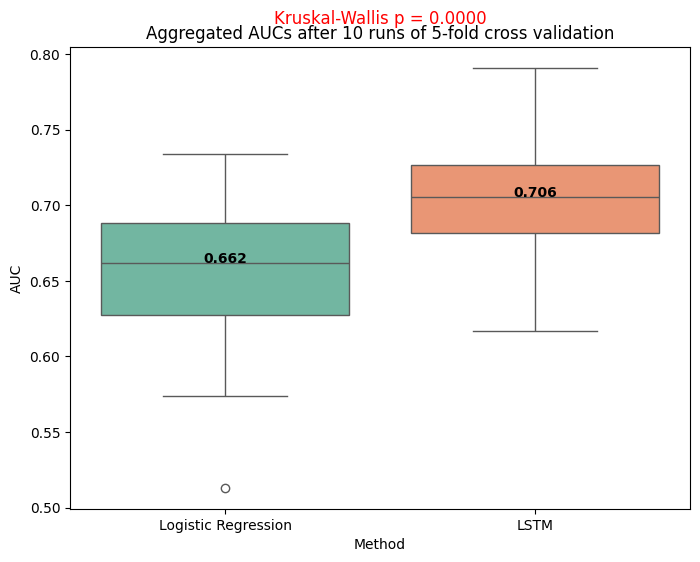

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Create the same DataFrame
df = pd.DataFrame({
    'Logistic Regression': lg_w,
    'LSTM': model,
})

# Melt into long format for Seaborn:
df_melted = df.melt(var_name='Method', value_name='AUC')

# Perform Kruskal-Wallis test
kruskal_stat, p_value = kruskal(df['Logistic Regression'], df['LSTM'])

# Create boxplot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Method', y='AUC', data=df_melted, palette='Set2')

yticks = np.arange(0.50, 0.85, 0.05)  # 0.50, 0.55, 0.60, ... 0.80
ax.set_yticks(yticks)

# Desired order for x-axis
desired_order = ["Logistic Regression", "LSTM"]

# Calculate medians per group
median_vals = df_melted.groupby('Method')['AUC'].median()

# Annotate each box with the median value
for i, method in enumerate(desired_order):
    median = median_vals[method]
    ax.text(
        i,
        median,  # Offset to avoid overlap with median line
        f"{median:.3f}",
        horizontalalignment='center',
        color='black',
        weight='semibold'
    )

# Display p-value
p_text = f"Kruskal-Wallis p = {p_value:.4f}"
plt.text(0.5, 0.82, p_text, horizontalalignment='center', fontsize=12, color='red')

# Updated title
plt.title("Aggregated AUCs after 10 runs of 5-fold cross validation")
plt.ylabel("AUC")
plt.show()


/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_27570/160225120.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Method', y='AUC', data=df_melted, palette='Set2')


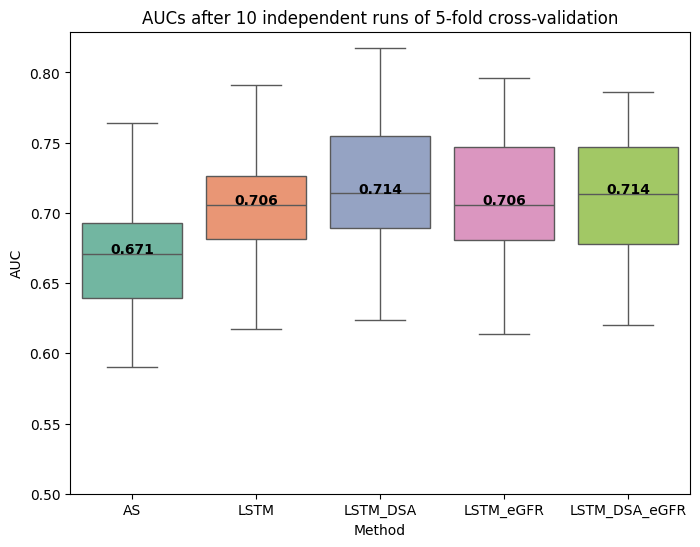

In [54]:
import seaborn as sns
# Create the same DataFrame
df = pd.DataFrame({
    'AS': AS,
    'LSTM': model,
    'LSTM_DSA': model_dsa,
    'LSTM_eGFR': model_egfr,
    'LSTM_DSA_eGFR': model_combo

})


# Melt into long format for Seaborn:
df_melted = df.melt(var_name='Method', value_name='AUC')

# Create boxplot
plt.figure(figsize=(8, 6))

ax = sns.boxplot(x='Method', y='AUC', data=df_melted, palette='Set2')
yticks = np.arange(0.50, 0.85, 0.05)  # 0.50, 0.55, 0.60, ... 0.80
ax.set_yticks(yticks)
# Desired order for x-axis
desired_order = ["AS", "LSTM", "LSTM_DSA", "LSTM_eGFR", "LSTM_DSA_eGFR"]
# Calculate medians per group
median_vals = df_melted.groupby('Method')['AUC'].median()

# Annotate each box with the median value
for i, method in enumerate(desired_order):
    median = median_vals[method]
    ax.text(
        i,
        median,  # Offset to avoid overlap with median line
        f"{median:.3f}",
        horizontalalignment='center',
        color='black',
        weight='semibold'
    )

# Updated title
plt.title("AUCs after 10 independent runs of 5-fold cross-validation")
plt.ylabel("AUC")
plt.show()

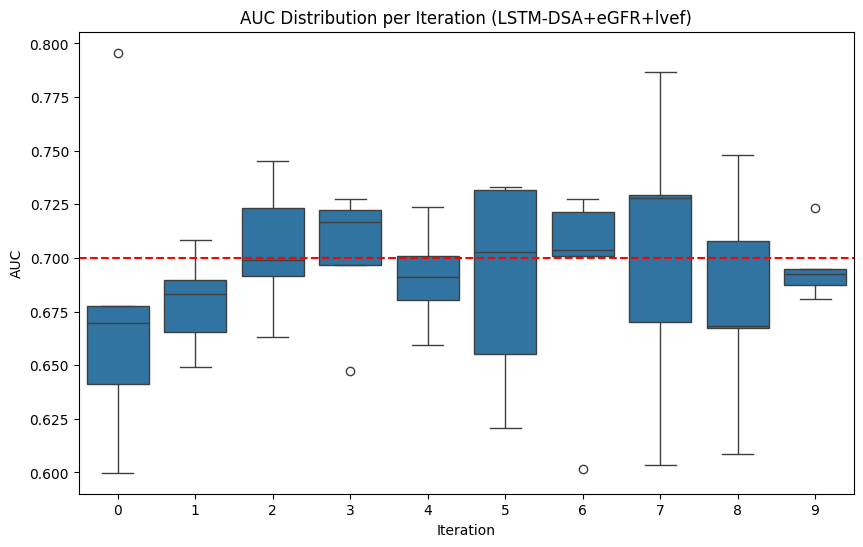

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume model_results_df has columns: 'Iteration', 'Split', 'AUC'
# Drop any duplicates of iteration-fold pairs if they exist
unique_df = model_results_df[['Iteration', 'Split', 'AUC']].drop_duplicates(subset=['Iteration', 'Split'])

plt.figure(figsize=(10,6))
sns.boxplot(x='Iteration', y='AUC', data=unique_df)
plt.title('AUC Distribution per Iteration (LSTM-DSA+eGFR+lvef)')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.axhline(y=0.70, color='red', linestyle='--')  # Draw a horizontal line at AUC=0.7

plt.show()

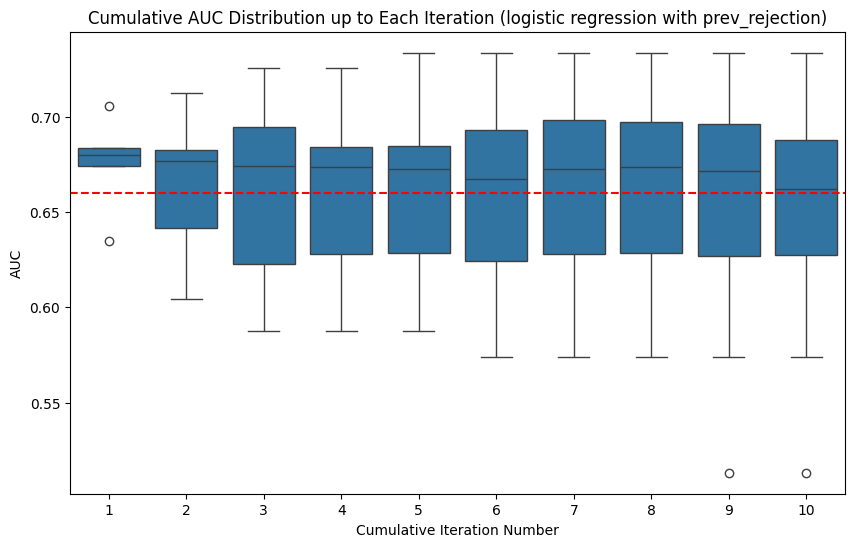

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop duplicates for unique folds per iteration again
unique_df = lg_results_w_df[['Iteration', 'Split', 'AUC']].drop_duplicates(subset=['Iteration', 'Split'])

# Suppose you have num_iterations total. If not known, you can infer from the data:
num_iterations = unique_df['Iteration'].max() + 1

# Create a cumulative DataFrame
# For iteration i, we include all folds from iteration 0 up to iteration i.
cumulative_data = []
for i in range(num_iterations):
    # Take all folds from iteration 0 to iteration i (inclusive)
    subset = unique_df[unique_df['Iteration'] <= i].copy()
    # Add a column to indicate this cumulative "view"
    subset['CumulativeIteration'] = i + 1  # Make it 1-based for readability
    cumulative_data.append(subset)

cumulative_data = pd.concat(cumulative_data, ignore_index=True)

plt.figure(figsize=(10,6))
sns.boxplot(x='CumulativeIteration', y='AUC', data=cumulative_data)
plt.title('Cumulative AUC Distribution up to Each Iteration (logistic regression with prev_rejection)')
plt.xlabel('Cumulative Iteration Number')
plt.ylabel('AUC')
plt.axhline(y=0.66, color='red', linestyle='--')  # Draw a horizontal line at AUC=0.7
plt.show()

# Visualization of metrics (need to redevelop this part for new dataformat)

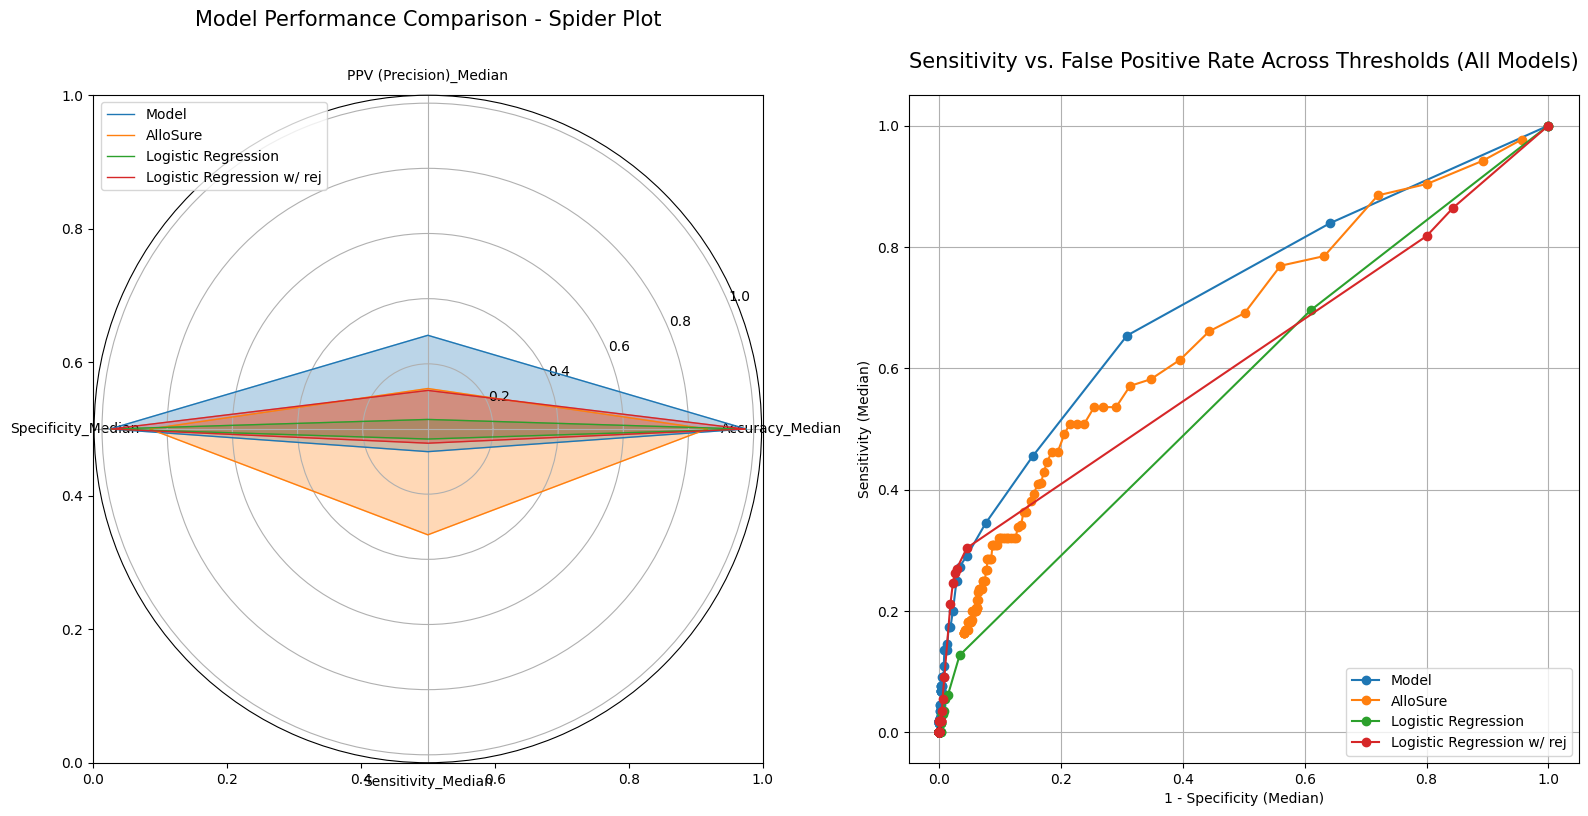

In [38]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

data = concatenated_results_vertical.copy()
# Preparing data for Spider Plot
metrics = ['Accuracy_Median', 'PPV (Precision)_Median', 'Specificity_Median', 'Sensitivity_Median']
models = data['Source'].unique()

# Normalizing data for fair comparison
normalized_data = data[metrics].copy()
for metric in metrics:
    normalized_data[metric] = (data[metric] - data[metric].min()) / (data[metric].max() - data[metric].min())

# Grouping by model and calculating mean values across thresholds
radar_data = normalized_data.groupby(data['Source']).mean()

# Setting up angles for radar plot
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist() + [0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors

# Creating two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plotting Spider Plot on ax1
ax1 = plt.subplot(121, polar=True)
for i, model in enumerate(models):
    values = radar_data.loc[model].tolist() + [radar_data.loc[model].tolist()[0]]
    ax1.plot(angles, values, linewidth=1, linestyle='solid', label=model, color=colors[i])
    ax1.fill(angles, values, color=colors[i], alpha=0.3)

ax1.set_title('Model Performance Comparison - Spider Plot', size=15, pad=50)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics)
ax1.legend(loc='upper left', bbox_to_anchor=(0., 1))

# Extracting all thresholds for all models for ax2
ax2 = plt.subplot(122)
for i, model in enumerate(models):
    model_data = data[data['Source'] == model]
    ax2.plot(1 - model_data['Specificity_Median'], model_data['Sensitivity_Median'], 
             marker='o', linestyle='-', label=model, color=colors[i])

ax2.set_title('Sensitivity vs. False Positive Rate Across Thresholds (All Models)', size=15, pad=20)
ax2.set_xlabel('1 - Specificity (Median)')
ax2.set_ylabel('Sensitivity (Median)')
ax2.legend(loc='lower right')
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


# Data Exploration

In [251]:
import pandas as pd

In [300]:
# Step 1: Statistical Summary of ady_dna
data = data_truncated.loc[data_truncated["avisitn"] != 9999]
ady_dna_summary = data[['usubjid', 'ady_dna', "avisitn", "aval_AlloSure", "aval_AlloMap"]].describe()
# print("Statistical Summary of ady_dna:")
print(ady_dna_summary)
# ady_dna_summary.to_csv("./Outputs/summary_15days_init-1_rawAS.csv")

# Label subjects based on whether they ever had a rejection
corrected_label = data.groupby('usubjid')['label'].apply(lambda x: 1 if x.max() == 1 else 0)
data = data.merge(corrected_label.rename('label_usubjid'), on = "usubjid", how = "left")

            ady_dna       avisitn  aval_AlloSure  aval_AlloMap
count  12612.000000  12612.000000   12612.000000  12612.000000
mean     294.991595    297.899302       0.232793     29.801855
std      259.961492    258.914812       0.769925      6.240519
min       16.000000     30.000000      -0.068665      2.000000
25%      124.000000    121.000000       0.026178     27.000000
50%      215.000000    182.000000       0.058880     31.000000
75%      356.000000    365.000000       0.140040     34.000000
max     2059.000000   2098.000000      16.983634     39.000000


<Axes: >

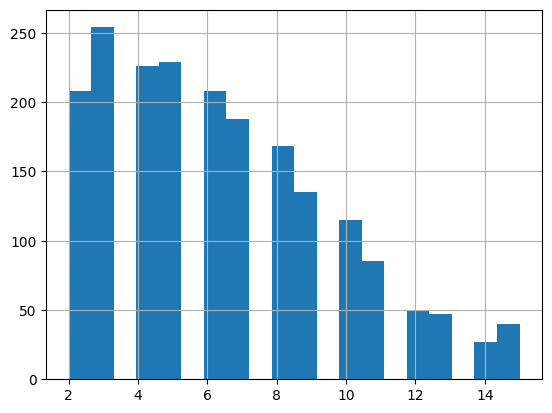

In [303]:
data['usubjid'].value_counts().hist(bins = 20)

In [304]:
data.drop_duplicates("usubjid")['label_usubjid'].value_counts()

label_usubjid
0    1672
1     307
Name: count, dtype: int64

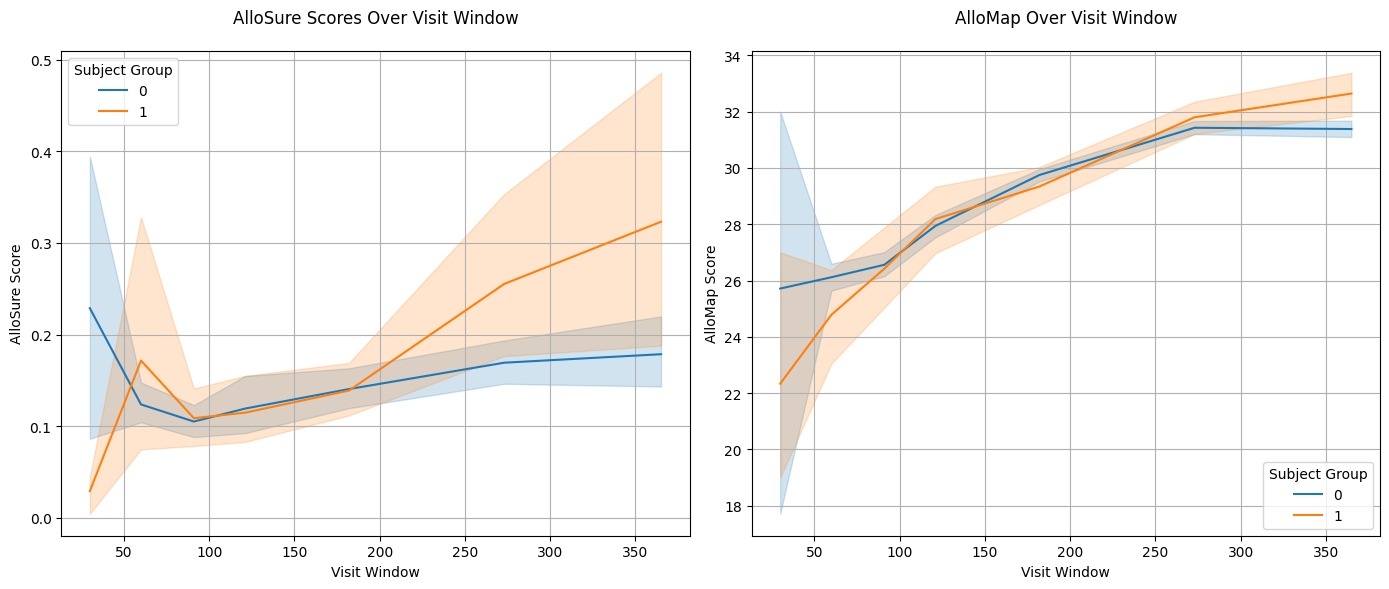

In [308]:
import seaborn as sns
import matplotlib.pyplot as plt


data = data.loc[data["ady_dna"] <= 365]
plt.figure(figsize=(14, 6))

# Smoothed plot for globally binned normalized AlloSure over time for the two groups
plt.subplot(1, 2, 1)
sns.lineplot(x='avisitn', y='aval_AlloSure', hue='label_usubjid', data=data)
plt.title('AlloSure Scores Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloSure Score')
plt.legend(title='Subject Group')
plt.grid(True)

# Smoothed plot for globally binned normalized AlloMap over time for the two groups
plt.subplot(1, 2, 2)
sns.lineplot(x='avisitn', y='aval_AlloMap', hue='label_usubjid', data=data)
plt.title('AlloMap Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloMap Score')
plt.legend(title='Subject Group')
plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: >

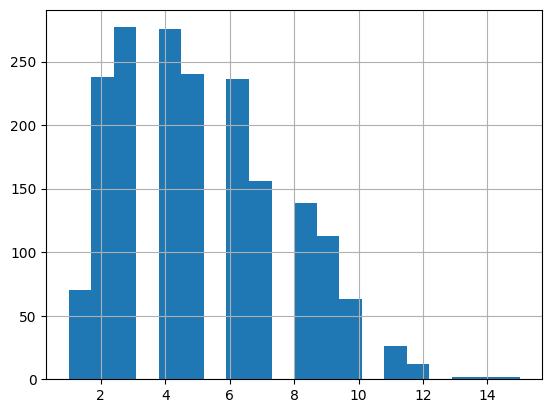

In [309]:
data['usubjid'].value_counts().hist(bins = 20)

# Inference of model and visualize

In [131]:
# Define the path where the model was saved
model_save_path = './Models/lstm_acr_5folds_10222024_rawAS_v2'

# Initialize the model with the same architecture
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Load the saved model parameters (state dictionary)
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_15418/1726975486.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

In [132]:
train_val_sequences, test_sequences, train_val_labels, test_labels, train_val_mask, test_mask, train_val_ids, test_ids = train_test_split(
    padded_sequences, padded_labels, valid_mask, usubjids, test_size=0.30, random_state=i
)
# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.6, 0.1)

# Step 1: Evaluate on the full dataset for all thresholds
full_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(padded_sequences, padded_labels, valid_mask, threshold)
    result['Dataset'] = 'Full Dataset'
    full_dataset_results.append(result)


# Step 2: Evaluate on the test dataset for all thresholds
test_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(test_sequences, test_labels, test_mask, threshold)
    result['Dataset'] = 'Test Dataset'
    test_dataset_results.append(result)

In [133]:
model.eval()
threshold = 0.03
with torch.no_grad():
    # Get model outputs (logits) for the dataset
    outputs = model(test_sequences).squeeze(-1)
    
    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(outputs)
    
    # Apply threshold to get binary predictions
    preds = (probs > threshold).float()

    # Convert tensors to numpy arrays for scikit-learn compatibility
    labels_np = test_labels.cpu().numpy()
    probs_np = probs.cpu().numpy()
    preds_np = preds.cpu().numpy()
    
    # Mask to ignore padded positions in the dataset
    mask_np = test_mask.cpu().numpy()
    valid_indices = mask_np == 1  # Only consider non-padded positions
    
    # Extract valid labels and predictions
    valid_labels = labels_np[valid_indices]
    valid_probs = probs_np[valid_indices]
    valid_preds = preds_np[valid_indices]

    # Calculate AUC
    auc = roc_auc_score(valid_labels, valid_probs)

    # Calculate accuracy
    accuracy = accuracy_score(valid_labels, valid_preds)

In [134]:
selected_id = data_truncated.loc[(data_truncated["usubjid"].isin(test_ids)) & (data_truncated["acr_yn"] == "Yes")]["usubjid"].unique()

In [135]:
test_data = data_truncated.loc[(data_truncated["usubjid"].isin(test_ids))]
test_data["pred"] = valid_preds
test_data["prob"] = valid_probs

/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_15418/2786555682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["pred"] = valid_preds
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_15418/2786555682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["prob"] = valid_probs


In [136]:
test_data = test_data[["usubjid", "ady_dna", "aval_AlloSure", "aval_AlloMap", "label", "acr_yn", "pred", "prob"]]

In [137]:
test_data.loc[test_data["aval_AlloSure"] >= 0.2, "pred_AS"] = 1
test_data.loc[test_data["aval_AlloSure"] < 0.2, "pred_AS"] = 0
test_data = test_data.loc[test_data["usubjid"].isin(selected_id)]

In [138]:
test_data["pred_diff"] = (test_data["pred"] == test_data["label"]).astype(float)
test_data["AS_diff"] = (test_data["pred_AS"] == test_data["label"]).astype(float)

In [139]:
test_data.groupby(["usubjid"])[["pred_diff", "AS_diff"]].sum()

pred_diff  AS_diff
usubjid                                    
CDNA-SN-C-00011-S01-140        7.0      4.0
CDNA-SN-C-00011-S02-100       10.0      7.0
CDNA-SN-C-00011-S03-001        9.0      8.0
CDNA-SN-C-00011-S03-032        3.0      4.0
CDNA-SN-C-00011-S03-039        5.0      5.0
CDNA-SN-C-00011-S03-099        2.0      2.0
CDNA-SN-C-00011-S03-111        3.0      4.0
CDNA-SN-C-00011-S05-010       11.0      4.0
CDNA-SN-C-00011-S05-075        7.0      9.0
CDNA-SN-C-00011-S07-041        8.0      7.0
CDNA-SN-C-00011-S07-054        9.0      6.0
CDNA-SN-C-00011-S08-003        1.0      2.0
CDNA-SN-C-00011-S08-042        4.0      6.0
CDNA-SN-C-00011-S09-016        4.0      2.0
CDNA-SN-C-00011-S11-018        7.0      4.0
CDNA-SN-C-00011-S11-024        6.0      5.0
CDNA-SN-C-00011-S11-036        5.0      6.0
CDNA-SN-C-00011-S13-009        7.0      4.0
CDNA-SN-C-00011-S13-028        7.0     10.0
CDNA-SN-C-00011-S13-032        8.0     11.0
CDNA-SN-C-00011-S13-035       10.0     10.0
CDNA-SN-C-00011-S13-043        9.0      1.0
CDNA-SN-C-00011-S13-071        7.0      6.0
CDNA-SN-C-00011-S13-079        5.0      7.0
CDNA-SN-C-00011-S17-001       10.0      9.0
CDNA-SN-C-00011-S17-097        9.0      5.0
CDNA-SN-C-00011-S17-100       10.0      9.0
CDNA-SN-C-00011-S17-104        9.0     10.0
CDNA-SN-C-00011-S17-118        8.0      9.0
CDNA-SN-C-00011-S17-129        7.0     10.0
CDNA-SN-C-00011-S19-026        2.0      3.0
CDNA-SN-C-00011-S20-006        6.0      5.0
CDNA-SN-C-00011-S21-012        3.0      4.0
CDNA-SN-C-00011-S21-017        3.0      4.0
CDNA-SN-C-00011-S22-004        7.0      6.0
CDNA-SN-C-00011-S23-026        1.0      3.0
CDNA-SN-C-00011-S25-014        2.0      2.0
CDNA-SN-C-00011-S26-029        4.0      3.0
CDNA-SN-C-00011-S27-015       10.0     12.0
CDNA-SN-C-00011-S31-063        3.0      3.0
CDNA-SN-C-00011-S31-067        1.0      4.0
CDNA-SN-C-00011-S38-016       10.0      9.0
CDNA-SN-C-00011-S38-039        4.0      6.0
CDNA-SN-C-00011-S40-002        4.0      4.0
CDNA-SN-C-00011-S40-010        9.0     10.0
CDNA-SN-C-00011-S42-004        5.0      7.0
CDNA-SN-C-00011-S43-004        9.0      8.0
CDNA-SN-C-00011-S44-003        2.0      4.0
CDNA-SN-C-00011-S44-026        2.0      5.0
CDNA-SN-C-00011-S45-025        9.0      7.0
CDNA-SN-C-00011-S50-006        8.0     10.0
CDNA-SN-C-00011-S50-007        7.0      8.0
CDNA-SN-C-00011-S50-014        5.0      6.0
CDNA-SN-C-00011-S52-007        5.0      4.0
CDNA-SN-C-00011-S61-013       11.0      9.0
CDNA-SN-C-00011-S64-021       10.0      8.0

##### CDNA-SN-C-00011-S64-016, CDNA-SN-C-00011-S45-033, CDNA-SN-C-00011-S03-039, CDNA-SN-C-00011-S31-024

In [140]:
test_data.loc[test_data["usubjid"] == "CDNA-SN-C-00011-S03-039"]

usubjid  ady_dna  aval_AlloSure  aval_AlloMap  label  \
1081  CDNA-SN-C-00011-S03-039       57       0.046811          24.0    0.0   
1082  CDNA-SN-C-00011-S03-039       71       0.049931          14.0    0.0   
1083  CDNA-SN-C-00011-S03-039      106       0.036081          26.0    0.0   
1084  CDNA-SN-C-00011-S03-039      144       1.325120          27.0    0.0   
1085  CDNA-SN-C-00011-S03-039      172       0.076878          26.0    1.0   
1086  CDNA-SN-C-00011-S03-039      200       0.010386          21.0    0.0   
1087  CDNA-SN-C-00011-S03-039      354       0.027190          33.0    0.0   

     acr_yn  pred      prob  pred_AS  pred_diff  AS_diff  
1081     No   0.0  0.014235      0.0        1.0      1.0  
1082     No   0.0  0.017367      0.0        1.0      1.0  
1083     No   1.0  0.035806      0.0        0.0      1.0  
1084     No   0.0  0.017480      1.0        1.0      0.0  
1085    Yes   0.0  0.027479      0.0        0.0      0.0  
1086     No   0.0  0.011578      0.0        1.0      1.0  
1087     No   0.0  0.017528      0.0        1.0      1.0

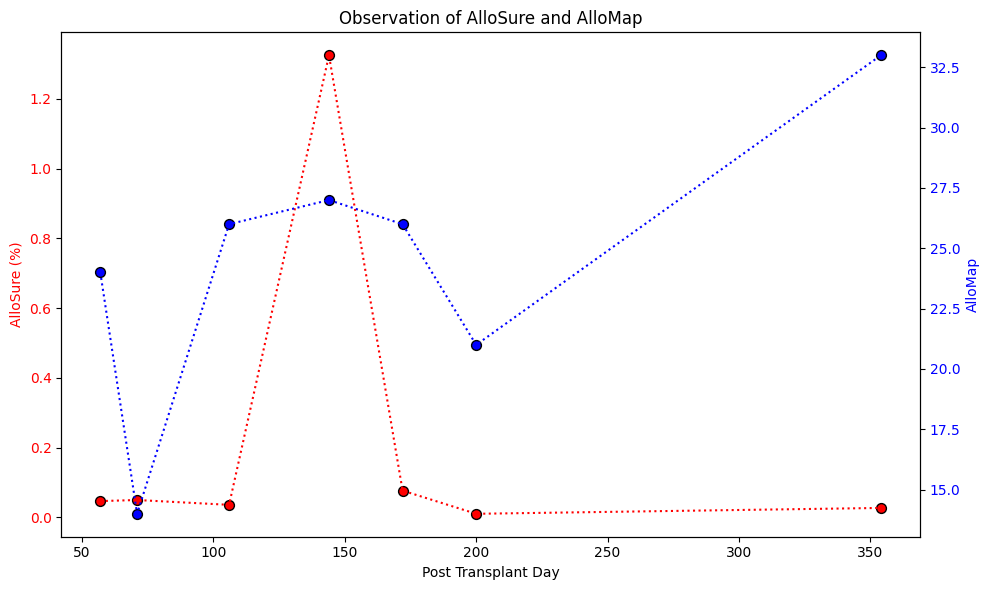

In [141]:

test_one = test_data.loc[test_data["usubjid"] == "CDNA-SN-C-00011-S03-039"]

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot "aval_AlloSure" on the primary y-axis with points highlighted
ax1.plot(test_one["ady_dna"], test_one["aval_AlloSure"], label="AS Observation", color='red', linestyle=':')
ax1.scatter(test_one["ady_dna"], test_one["aval_AlloSure"], color='red', s=50, label="AS Points", edgecolors='black')
ax1.set_xlabel('Post Transplant Day')
ax1.set_ylabel('AlloSure (%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis with points highlighted
ax2 = ax1.twinx()
ax2.plot(test_one["ady_dna"], test_one["aval_AlloMap"], label='AM Observation', color='blue', linestyle=':')
ax2.scatter(test_one["ady_dna"], test_one["aval_AlloMap"], color='blue', s=50, label="AM Points", edgecolors='black')
ax2.set_ylabel('AlloMap', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title and legends
plt.title('Observation of AlloSure and AlloMap')
fig.tight_layout()

# Show the plot
plt.show()
